In [1]:
import pandas as pd
import numpy as np
import math as mp
from sklearn.model_selection import StratifiedKFold, train_test_split
import time
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm_notebook
from bayes_opt import BayesianOptimization
import ujson as json
import os
import pickle as pkl
import featuretools as ft
from boruta import BorutaPy

In [ ]:
roc_auc_score(y_train, model.predict(X_train))

In [160]:
roc_auc_score(y_train, model.predict(X_train, num_iteration=model.best_iteration))

0.9145011777160599

In [2]:
train_data = pd.read_csv('train_features.csv', index_col='match_id_hash')
test_data = pd.read_csv('test_features.csv', index_col='match_id_hash')
y_train = pd.read_csv('train_targets.csv', index_col='match_id_hash')['radiant_win'].map({True: 1, False:0})

In [4]:
y_train = y_train[X_train.index]

In [ ]:
y_train.shape

In [ ]:
X_train.shape

In [ ]:
X_train = train_data[['game_time', 'objectives_len']].copy()
X_test = test_data[['game_time', 'objectives_len']].copy()

mean_cols = ['kills','deaths', 'assists','denies','gold', 'lh','xp','health','max_health','max_mana', \
             'level', 'stuns','creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', \
             'teamfight_participation','towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']

In [ ]:
mean_cols = ['kills','deaths', 'assists','denies','gold', 'lh','xp','health','max_health','max_mana', \
             'level', 'stuns','creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', \
             'teamfight_participation','towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']

for col in tqdm_notebook(mean_cols):
    for let in ['r','d']:
        full_cols = [x + col for x in [let +'%s_' %i for i in range(1, 6)]]
        X_train[let + '_' + col] = train_data[full_cols].sum(axis = 1).values
        X_train[let+col+'_mean'] = train_data[full_cols].apply(np.mean, axis=1)
        X_train[let+col+'_max'] = train_data[full_cols].apply(np.max, axis=1)
        X_train[let+col+'_min'] = train_data[full_cols].apply(np.min, axis=1)

In [ ]:
for col in tqdm_notebook(mean_cols):
    for let in ['r','d']:
        full_cols = [x + col for x in [let +'%s_' %i for i in range(1, 6)]]
        X_train[let + '_' + col] = train_data[full_cols].sum(axis = 1).values
        X_train[let+col+'_mean'] = train_data[full_cols].apply(np.mean, axis=1)
        X_train[let+col+'_max'] = train_data[full_cols].apply(np.max, axis=1)
        X_train[let+col+'_min'] = train_data[full_cols].apply(np.min, axis=1)

        
for col in tqdm_notebook(mean_cols):
    for let in ['r','d']:
        full_cols = [x + col for x in [let +'%s_' %i for i in range(1, 6)]]
        X_test[let + '_' + col] = test_data[full_cols].sum(axis = 1).values
        X_test[let+col+'_mean'] = test_data[full_cols].apply(np.mean, axis=1)
        X_test[let+col+'_max'] = test_data[full_cols].apply(np.max, axis=1)
        X_test[let+col+'_min'] = test_data[full_cols].apply(np.min, axis=1)


In [3]:
with open('X_train_84.pkl', 'rb') as f:
    X_train = pkl.load(f)
with open('X_test_84.pkl', 'rb') as f:
    X_test = pkl.load(f)

In [140]:
with open('X_train.pkl', 'rb') as f:
    X_train = pkl.load(f)
with open('X_test.pkl', 'rb') as f:
    X_test = pkl.load(f)

In [ ]:
with open('df_train.pkl', 'rb') as f:
    df_train = pkl.load(f)
with open('df_test.pkl', 'rb') as f:
    df_test = pkl.load(f)

In [ ]:
X_train = pd.concat([X_train, X_train], axis=0, join='inner')
y_train = pd.concat([y_train, y_train], axis=0, join='inner')

In [ ]:
#X_train = train_data[['game_time', 'objectives_len']].copy()
mean_cols = ['x', 'y']
for col in tqdm_notebook(mean_cols):
    for let in ['r','d']:
        full_cols = [x + col for x in [let +'%s_' %i for i in range(1, 6)]]
        X_train[let+col+'_mean'] = train_data[full_cols].apply(np.mean, axis=1)
        X_test[let+col+'_mean'] = test_data[full_cols].apply(np.mean, axis=1)

In [142]:
X_train['r_gpm'] =  X_train['r_gold'] / X_train['game_time']
X_train['d_gpm'] =  X_train['d_gold'] / X_train['game_time']

X_test['r_gpm'] =  X_test['r_gold'] / X_test['game_time']
X_test['d_gpm'] =  X_test['d_gold'] / X_test['game_time']

In [ ]:
#X_test.drop(columns = ['rx_mean', 'dx_mean', 'ry_mean', 'dy_mean'], inplace = True, axis = 0)
X_train.drop(columns = ['r_tf','d_tf'], inplace = True, axis = 1)
X_test.drop(columns = ['r_tf','d_tf'], inplace = True, axis = 1)

In [ ]:
X_test.drop(columns = ['rx_mean', 'dx_mean', 'ry_mean', 'dy_mean',], inplace = True, axis = 0)
X_train.drop(columns = ['value'], inplace = True, axis = 0)

In [141]:
X_test.drop(columns = ['r_obs_placed',
       'robs_placed_mean', 'robs_placed_max', 'robs_placed_min',
       'd_obs_placed', 'dobs_placed_mean', 'dobs_placed_max',
       'dobs_placed_min', 'r_sen_placed', 'rsen_placed_mean',
       'rsen_placed_max', 'rsen_placed_min', 'd_sen_placed',
       'dsen_placed_mean', 'dsen_placed_max', 'dsen_placed_min',
       'rx_mean', 'dx_mean', 'ry_mean', 'dy_mean'], inplace = True, axis = 1)

X_train.drop(columns = ['r_obs_placed',
       'robs_placed_mean', 'robs_placed_max', 'robs_placed_min',
       'd_obs_placed', 'dobs_placed_mean', 'dobs_placed_max',
       'dobs_placed_min', 'r_sen_placed', 'rsen_placed_mean',
       'rsen_placed_max', 'rsen_placed_min', 'd_sen_placed',
       'dsen_placed_mean', 'dsen_placed_max', 'dsen_placed_min',
       'rx_mean', 'dx_mean', 'ry_mean', 'dy_mean'], inplace = True, axis = 1)

In [ ]:
X_test.drop(columns = ['r_kills', 'rkills_mean', 'rkills_max', 'rkills_min',
       'd_kills', 'dkills_mean', 'dkills_max', 'dkills_min', 'r_deaths', 'r_denies',
       'rdenies_mean', 'rdenies_max', 'rdenies_min', 'd_denies',
       'ddenies_mean', 'ddenies_max', 'ddenies_min',
                      'r_towers_killed', 'rtowers_killed_mean', 'rtowers_killed_max',
       'rtowers_killed_min', 'd_towers_killed', 'dtowers_killed_mean',
       'dtowers_killed_max', 'dtowers_killed_min'], inplace = True, axis = 0)

X_train.drop(columns = ['r_kills', 'rkills_mean', 'rkills_max', 'rkills_min',
       'd_kills', 'dkills_mean', 'dkills_max', 'dkills_min', 'r_deaths',
                       'r_denies',
       'rdenies_mean', 'rdenies_max', 'rdenies_min', 'd_denies',
       'ddenies_mean', 'ddenies_max', 'ddenies_min',
                       'r_towers_killed', 'rtowers_killed_mean', 'rtowers_killed_max',
       'rtowers_killed_min', 'd_towers_killed', 'dtowers_killed_mean',
       'dtowers_killed_max', 'dtowers_killed_min'], inplace = True, axis = 0)

In [ ]:
#Better to save extracted data in files, because extracting takes time...
X_train.to_pickle('X_train_84.pkl')
X_test.to_pickle('X_test_84.pkl')

In [143]:
X_train['r_xppm'] = X_train['r_xp'] / X_train['game_time']
X_train['d_xppm'] = X_train['d_xp'] / X_train['game_time']
                    
X_test['r_xppm'] = X_test['r_xp'] / X_test['game_time']
X_test['d_xppm'] = X_test['d_xp'] / X_test['game_time']

In [144]:
X_train['value_r'] = (X_train['r_kills'] + X_train['r_lh'] + X_train['r_assists']  + \
X_train['r_towers_killed'] + X_train['r_roshans_killed'] + X_train['r_firstblood_claimed']) / X_train['game_time']

X_test['value_r'] = (X_test['r_kills'] + X_test['r_lh'] + X_test['r_assists']  + \
X_test['r_towers_killed'] + X_test['r_roshans_killed'] + X_test['r_firstblood_claimed']) / X_test['game_time'] 

In [145]:
X_train['value_d'] = (X_train['d_kills'] + X_train['d_lh'] + X_train['d_assists']  + \
X_train['d_towers_killed'] + X_train['d_roshans_killed'] + X_train['d_firstblood_claimed']) / X_train['game_time']

X_test['value_d'] = (X_test['d_kills'] + X_test['d_lh'] + X_test['d_assists']  + \
X_test['d_towers_killed'] + X_test['d_roshans_killed'] + X_test['d_firstblood_claimed']) / X_test['game_time'] 

In [146]:
df_test = df_test.fillna(0)
df_test = df_test.replace([np.inf, -np.inf], 0)
df_test = df_test.astype(int)

In [ ]:
X_train.shape

In [168]:
X_train.columns.values

array(['game_time', 'game_mode', 'lobby_type', 'objectives_len',
       'chat_len', 'r_kills', 'rkills_mean', 'rkills_max', 'rkills_min',
       'd_kills', 'dkills_mean', 'dkills_max', 'dkills_min', 'r_deaths',
       'rdeaths_mean', 'rdeaths_max', 'rdeaths_min', 'd_deaths',
       'ddeaths_mean', 'ddeaths_max', 'ddeaths_min', 'r_assists',
       'rassists_mean', 'rassists_max', 'rassists_min', 'd_assists',
       'dassists_mean', 'dassists_max', 'dassists_min', 'r_denies',
       'rdenies_mean', 'rdenies_max', 'rdenies_min', 'd_denies',
       'ddenies_mean', 'ddenies_max', 'ddenies_min', 'r_gold',
       'rgold_mean', 'rgold_max', 'rgold_min', 'd_gold', 'dgold_mean',
       'dgold_max', 'dgold_min', 'r_lh', 'rlh_mean', 'rlh_max', 'rlh_min',
       'd_lh', 'dlh_mean', 'dlh_max', 'dlh_min', 'r_xp', 'rxp_mean',
       'rxp_max', 'rxp_min', 'd_xp', 'dxp_mean', 'dxp_max', 'dxp_min',
       'r_health', 'rhealth_mean', 'rhealth_max', 'rhealth_min',
       'd_health', 'dhealth_mean', 'dhealt

In [163]:
X_train['tower_diff']  = X_train['r_towers_killed'] - X_train['d_towers_killed']

X_test['tower_diff']  = X_test['r_towers_killed'] - X_test['d_towers_killed']

In [167]:
X_train.drop(columns = ['tower_diff'], inplace = True, axis = 1)
X_test.drop(columns = ['tower_diff'], inplace = True, axis = 1)

In [ ]:
def hero_dammies(train_data, test_data, let):
    r_cols = [let +'%s_hero_id' %i for i in range(1, 6)]
    X = pd.concat([train_data, test_data])
    X['herois'+ let] = X.apply(lambda row: ' '.join(row.loc[r_cols].map(int).map(str)), axis=1)
    cvv = CountVectorizer()
    heroes = pd.DataFrame(cvv.fit_transform(X['herois'+let]).todense(), columns=cvv.get_feature_names(), index=X.index)
    return heroes.loc[train_data.index], heroes.loc[test_data.index]

In [ ]:
%%time
train_r, test_r = hero_dammies(train_data, test_data, 'r')
train_d, test_d = hero_dammies(train_data, test_data, 'd')

In [ ]:
let = 'r'
r_cols = [let +'%s_hero_id' %i for i in range(1, 6)]
X = pd.concat([train_data, test_data])
X['herois'+ let] = X.apply(lambda row: ' '.join(row.loc[r_cols].map(int).map(str)), axis=1)
cvv = CountVectorizer()
heroes = pd.DataFrame(cvv.fit_transform(X['herois'+let]).todense(), columns=cvv.get_feature_names(), index=X.index)
train_r, test_r = heroes.loc[train_data.index], heroes.loc[test_data.index]

let = 'd'
r_cols = [let +'%s_hero_id' %i for i in range(1, 6)]
X = pd.concat([train_data, test_data])
X['herois'+ let] = X.apply(lambda row: ' '.join(row.loc[r_cols].map(int).map(str)), axis=1)
cvv = CountVectorizer()
heroes = pd.DataFrame(cvv.fit_transform(X['herois'+let]).todense(), columns=cvv.get_feature_names(), index=X.index)
train_d, test_d = heroes.loc[train_data.index], heroes.loc[test_data.index]

In [ ]:
X_train = X_train.join(train_r, rsuffix='_r').join(train_d, rsuffix='_d')

X_test = X_test.join(test_r, rsuffix='_r').join(test_d, rsuffix='_d')

In [5]:
def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf):
    params = {
    "objective" : "binary",
    "metric" : "auc", 
    'is_unbalance': True,
    "num_leaves" : int(num_leaves),
    "max_depth" : int(max_depth),
    "lambda_l2" : lambda_l2,
    "lambda_l1" : lambda_l1,
    "num_threads" : 20,
    "min_child_samples" : int(min_child_samples),
    'min_data_in_leaf': int(min_data_in_leaf),
    "learning_rate" : 0.03,
    "subsample_freq" : 5,
    "bagging_seed" : 42,
    "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgb.cv(params,
                       lgtrain,
                       10000,
                       early_stopping_rounds=400,
                       stratified=True,
                       nfold=5)
    return cv_result['auc-mean'][-1]

def lgb_train(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf):
    params = {
    "objective" : "binary",
    "metric" : "auc", 
    'is_unbalance': True,
    "num_leaves" : int(num_leaves),
    "max_depth" : int(max_depth),
    "lambda_l2" : lambda_l2,
    "lambda_l1" : lambda_l1,
    "num_threads" : 20,
    "min_child_samples" : int(min_child_samples),
    'min_data_in_leaf': int(min_data_in_leaf),
    "learning_rate" : 0.03,
    "subsample_freq" : 5,
    "bagging_seed" : 42,
    'nthread': 4,
    "verbosity" : 2
    }
    t_x,v_x,t_y,v_y = train_test_split(X_train, y_train,test_size=0.2)
    lgtrain = lgb.Dataset(t_x, t_y)
    lgvalid = lgb.Dataset(v_x, v_y)
    
    #lgtrain = lgb.Dataset(X_train, y_train,categorical_feature=categorical_features)
    #model = lgb.train(params, lgtrain, 4000, verbose_eval=200)


    model = lgb.train(params, lgtrain, 200000, valid_sets=[lgvalid], early_stopping_rounds=800, verbose_eval=200)
    pred_test_y = model.predict(X_test, num_iteration=model.best_iteration)
    return pred_test_y, model
    
def param_tuning(init_points,num_iter,**args):
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (22, 200),
                                                'max_depth': (60, 65),
                                                'lambda_l2': (0.0, 7),
                                                'lambda_l1': (2.0, 5),
                                                'min_child_samples': (80, 5000),
                                                'min_data_in_leaf': (298, 400)
                                                })

    lgbBO.maximize(init_points=init_points, n_iter=num_iter,**args)
    return lgbBO

In [6]:
categorical_features= ['lobby_type', 'game_mode']

In [ ]:
result = param_tuning(10,50)

In [ ]:
params3 = result.max['params']

In [7]:
params = {'lambda_l1': 2.7854826462118,
 'lambda_l2': 6.360595715717438,
 'max_depth': 61.37953689381397,
 'min_child_samples': 90.7415016589367,
 'min_data_in_leaf': 399.94831390946,
 'num_leaves': 22.474263042820745}

In [ ]:
params = {'lambda_l1': 2.9474783640215523,
 'lambda_l2': 4.763069497874695,
 'max_depth': 62.09386520054763,
 'min_child_samples': 93.05109990569608,
 'min_data_in_leaf': 299.7260828478734,
 'num_leaves': 23.61638355559217}

In [ ]:
params2 = result.max['params']

In [ ]:
params2

In [ ]:
params = {'lambda_l1': 3.3483782188386053,
 'lambda_l2': 0.4710921246688088,
 'max_depth': 61.1702877191018,
 'min_child_samples': 85.41278882818256,
 'min_data_in_leaf': 297.8755555483252,
 'num_leaves': 25.672866108605408}

In [ ]:
params

In [151]:
X_train = pd.concat([X_train, df_train], axis=1, join='inner')
X_test = pd.concat([X_test, df_test], axis=1, join='inner')

In [152]:
for team in 'r', 'd':
        consumble_columns = ['branches', 'courier','dust','infused_raindrop',
                            'orb_of_venom', 'tome_of_knowledge', 'tango_single',
                         
                             
                             'smoke_of_deceit']
        
        starts_with = f'{team}_item_'
        consumble_columns = [starts_with + column for column in consumble_columns]
        X_train.drop(columns=consumble_columns, inplace=True)
        X_test.drop(columns=consumble_columns, inplace=True)

In [153]:
X_train = X_train.fillna(0)

In [154]:
X_test = X_test.fillna(0)

In [8]:
pred_test_y1,model1 = lgb_train(**params)
pred_test_y2, model2 = lgb_train(**params)
pred_test_y3, model3 = lgb_train(**params)
pred_test_y4, model4 = lgb_train(**params)
pred_test_y5, model5 = lgb_train(**params)
y_pred = (pred_test_y1 + pred_test_y2 + pred_test_y3 + pred_test_y4 + pred_test_y5)/5

Training until validation scores don't improve for 800 rounds.
[200]	valid_0's auc: 0.842311
[400]	valid_0's auc: 0.850701
[600]	valid_0's auc: 0.85325
[800]	valid_0's auc: 0.854023
[1000]	valid_0's auc: 0.85425
[1200]	valid_0's auc: 0.85409
[1400]	valid_0's auc: 0.853508
[1600]	valid_0's auc: 0.852871
Early stopping, best iteration is:
[944]	valid_0's auc: 0.854418
Training until validation scores don't improve for 800 rounds.
[200]	valid_0's auc: 0.834889
[400]	valid_0's auc: 0.84426
[600]	valid_0's auc: 0.847692
[800]	valid_0's auc: 0.848768
[1000]	valid_0's auc: 0.849181
[1200]	valid_0's auc: 0.849252
[1400]	valid_0's auc: 0.848997
[1600]	valid_0's auc: 0.848568
[1800]	valid_0's auc: 0.848285
Early stopping, best iteration is:
[1075]	valid_0's auc: 0.849318
Training until validation scores don't improve for 800 rounds.
[200]	valid_0's auc: 0.838183
[400]	valid_0's auc: 0.846436
[600]	valid_0's auc: 0.849058
[800]	valid_0's auc: 0.850232
[1000]	valid_0's auc: 0.850468
[1200]	valid_0

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

grid_param = {"max_iter":range(100, 500)}
gs = GridSearchCV(LogisticRegression(n_jobs = -1, verbose = 3, warm_start = True),\
             grid_param, make_scorer(roc_auc_score), verbose=3)

In [6]:
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [7]:
clf = CatBoostClassifier(thread_count=4,
                         loss_function='Logloss',
                        
                         od_type = 'Iter',
                         verbose= False
                        )

In [8]:
search_spaces = {'iterations': Integer(10, 1000),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight':Real(0.01, 1.0, 'uniform')}

In [ ]:
fit_params=None, iid=True, n_iter=10, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring=None,
       search_spaces={'C': (0.01, 100.0, 'log-uniform')}, verbose=0)
 

In [28]:
opt = GridSearchCV(clf,
                    search_spaces,
                    scoring=roc_auc,
                    cv=skf)

NameError: name 'GridSearchCV' is not defined

In [15]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [16]:
best_params = report_perf(opt, df_train_features, y_target,'CatBoost', 
                          callbacks=[VerboseCallback(100), 
                                     DeadlineStopper(60*10)])


NameError: name 'opt' is not defined

In [5]:
from catboost import CatBoostClassifier, Pool
from skopt.space import Real, Categorical, Integer

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [13]:
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper

In [74]:
best_params={'bagging_temperature': 0.41010395885331385,
 'border_count': 186,
 'depth': 8,
 'iterations': 323,
 'l2_leaf_reg': 21,
 'learning_rate': 0.0673344419215237,
 'random_strength': 3.230824361824754e-06,
 'scale_pos_weight': 0.7421091918485163}

In [66]:
best_params['iterations']=1000

In [75]:
tuned_model = CatBoostClassifier(**best_params,task_type = "CPU",od_type='Iter',one_hot_max_size=10)
tuned_model.fit(X_train, y_train)
roc_auc_score(y_train, tuned_model.predict(X_train))
ans = pd.DataFrame({'one':model1.predict(X_train), 'two':tuned_model.predict_proba(X_train)})

0:	learn: 0.6691557	total: 827ms	remaining: 4m 26s
1:	learn: 0.6485504	total: 1.58s	remaining: 4m 13s
2:	learn: 0.6302290	total: 2.66s	remaining: 4m 44s
3:	learn: 0.6157782	total: 3.52s	remaining: 4m 40s
4:	learn: 0.6036103	total: 4.2s	remaining: 4m 27s
5:	learn: 0.5936576	total: 4.88s	remaining: 4m 17s
6:	learn: 0.5848382	total: 5.56s	remaining: 4m 10s
7:	learn: 0.5758021	total: 6.23s	remaining: 4m 5s
8:	learn: 0.5678897	total: 6.89s	remaining: 4m
9:	learn: 0.5614738	total: 7.53s	remaining: 3m 55s
10:	learn: 0.5559314	total: 8.18s	remaining: 3m 52s
11:	learn: 0.5509772	total: 8.85s	remaining: 3m 49s
12:	learn: 0.5461733	total: 9.5s	remaining: 3m 46s
13:	learn: 0.5422476	total: 10.1s	remaining: 3m 43s
14:	learn: 0.5387122	total: 10.8s	remaining: 3m 42s
15:	learn: 0.5357559	total: 11.4s	remaining: 3m 39s
16:	learn: 0.5328072	total: 12.1s	remaining: 3m 37s
17:	learn: 0.5304365	total: 12.7s	remaining: 3m 35s
18:	learn: 0.5279314	total: 13.4s	remaining: 3m 34s
19:	learn: 0.5254448	total: 1

157:	learn: 0.4553265	total: 1m 44s	remaining: 1m 49s
158:	learn: 0.4550586	total: 1m 45s	remaining: 1m 48s
159:	learn: 0.4548364	total: 1m 46s	remaining: 1m 48s
160:	learn: 0.4545803	total: 1m 46s	remaining: 1m 47s
161:	learn: 0.4543763	total: 1m 47s	remaining: 1m 46s
162:	learn: 0.4541836	total: 1m 47s	remaining: 1m 45s
163:	learn: 0.4539569	total: 1m 48s	remaining: 1m 45s
164:	learn: 0.4537662	total: 1m 49s	remaining: 1m 44s
165:	learn: 0.4535280	total: 1m 49s	remaining: 1m 43s
166:	learn: 0.4532579	total: 1m 50s	remaining: 1m 43s
167:	learn: 0.4530633	total: 1m 51s	remaining: 1m 42s
168:	learn: 0.4528036	total: 1m 51s	remaining: 1m 41s
169:	learn: 0.4525729	total: 1m 52s	remaining: 1m 41s
170:	learn: 0.4522866	total: 1m 53s	remaining: 1m 40s
171:	learn: 0.4520856	total: 1m 53s	remaining: 1m 39s
172:	learn: 0.4519324	total: 1m 54s	remaining: 1m 39s
173:	learn: 0.4517040	total: 1m 55s	remaining: 1m 38s
174:	learn: 0.4514472	total: 1m 55s	remaining: 1m 37s
175:	learn: 0.4511770	total:

312:	learn: 0.4285565	total: 3m 25s	remaining: 6.55s
313:	learn: 0.4284791	total: 3m 25s	remaining: 5.9s
314:	learn: 0.4283088	total: 3m 26s	remaining: 5.24s
315:	learn: 0.4281819	total: 3m 27s	remaining: 4.58s
316:	learn: 0.4280003	total: 3m 27s	remaining: 3.93s
317:	learn: 0.4278938	total: 3m 28s	remaining: 3.27s
318:	learn: 0.4276834	total: 3m 28s	remaining: 2.62s
319:	learn: 0.4274777	total: 3m 29s	remaining: 1.96s
320:	learn: 0.4273197	total: 3m 30s	remaining: 1.31s
321:	learn: 0.4271492	total: 3m 30s	remaining: 655ms
322:	learn: 0.4269484	total: 3m 31s	remaining: 0us


Exception: Data must be 1-dimensional

In [76]:
roc_auc_score(y_train, tuned_model.predict(X_train))

0.7971994449571008

In [51]:
ans = pd.DataFrame({'one':model1.predict(X_train), 'two':model2.predict(X_train), 'three':model3.predict(X_train), \
                   'four':model4.predict(X_train), 'five':model5.predict(X_train)})

In [60]:
gs.fit(ans, y_train)

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
[CV] max_iter=100 ....................................................
[LibLinear][CV] ............ max_iter=100, score=0.831623351995053, total=   0.0s
[CV] max_iter=100 ....................................................
[LibLinear][CV] ........... max_iter=100, score=0.8328437816050155, total=   0.1s
[CV] max_iter=100 ....................................................
[LibLinear][CV] ............ max_iter=100, score=0.831852184946998, total=   0.1s
[CV] max_iter=101 ....................................................
[LibLinear][CV] ............ max_iter=101, score=0.831623351995053, total=   0.1s
[CV] max_iter=101 ....................................................
[LibLinear][CV] ........... max_iter=101, score=0.8328437816050155, total=   0.1s
[CV] max_iter=101 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=101, score=0.831852184946998, total=   0.1s
[CV] max_iter=102 ....................................................
[LibLinear][CV] ............ max_iter=102, score=0.831623351995053, total=   0.1s
[CV] max_iter=102 ....................................................
[LibLinear][CV] ........... max_iter=102, score=0.8328437816050155, total=   0.1s
[CV] max_iter=102 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=102, score=0.831852184946998, total=   0.1s
[CV] max_iter=103 ....................................................
[LibLinear][CV] ............ max_iter=103, score=0.831623351995053, total=   0.1s
[CV] max_iter=103 ....................................................
[LibLinear][CV] ........... max_iter=103, score=0.8328437816050155, total=   0.1s
[CV] max_iter=103 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=103, score=0.831852184946998, total=   0.1s
[CV] max_iter=104 ....................................................
[LibLinear][CV] ............ max_iter=104, score=0.831623351995053, total=   0.1s
[CV] max_iter=104 ....................................................
[LibLinear][CV] ........... max_iter=104, score=0.8328437816050155, total=   0.1s
[CV] max_iter=104 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=104, score=0.831852184946998, total=   0.1s
[CV] max_iter=105 ....................................................
[LibLinear][CV] ............ max_iter=105, score=0.831623351995053, total=   0.1s
[CV] max_iter=105 ....................................................
[LibLinear][CV] ........... max_iter=105, score=0.8328437816050155, total=   0.1s
[CV] max_iter=105 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=105, score=0.831852184946998, total=   0.1s
[CV] max_iter=106 ....................................................
[LibLinear][CV] ............ max_iter=106, score=0.831623351995053, total=   0.1s
[CV] max_iter=106 ....................................................
[LibLinear][CV] ........... max_iter=106, score=0.8328437816050155, total=   0.1s
[CV] max_iter=106 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=106, score=0.831852184946998, total=   0.1s
[CV] max_iter=107 ....................................................
[LibLinear][CV] ............ max_iter=107, score=0.831623351995053, total=   0.1s
[CV] max_iter=107 ....................................................
[LibLinear][CV] ........... max_iter=107, score=0.8328437816050155, total=   0.1s
[CV] max_iter=107 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=107, score=0.831852184946998, total=   0.1s
[CV] max_iter=108 ....................................................
[LibLinear][CV] ............ max_iter=108, score=0.831623351995053, total=   0.1s
[CV] max_iter=108 ....................................................
[LibLinear][CV] ........... max_iter=108, score=0.8328437816050155, total=   0.1s
[CV] max_iter=108 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=108, score=0.831852184946998, total=   0.1s
[CV] max_iter=109 ....................................................
[LibLinear][CV] ............ max_iter=109, score=0.831623351995053, total=   0.1s
[CV] max_iter=109 ....................................................
[LibLinear][CV] ........... max_iter=109, score=0.8328437816050155, total=   0.1s
[CV] max_iter=109 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=109, score=0.831852184946998, total=   0.1s
[CV] max_iter=110 ....................................................
[LibLinear][CV] ............ max_iter=110, score=0.831623351995053, total=   0.1s
[CV] max_iter=110 ....................................................
[LibLinear][CV] ........... max_iter=110, score=0.8328437816050155, total=   0.1s
[CV] max_iter=110 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=110, score=0.831852184946998, total=   0.1s
[CV] max_iter=111 ....................................................
[LibLinear][CV] ............ max_iter=111, score=0.831623351995053, total=   0.1s
[CV] max_iter=111 ....................................................
[LibLinear][CV] ........... max_iter=111, score=0.8328437816050155, total=   0.1s
[CV] max_iter=111 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=111, score=0.831852184946998, total=   0.1s
[CV] max_iter=112 ....................................................
[LibLinear][CV] ............ max_iter=112, score=0.831623351995053, total=   0.1s
[CV] max_iter=112 ....................................................
[LibLinear][CV] ........... max_iter=112, score=0.8328437816050155, total=   0.1s
[CV] max_iter=112 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=112, score=0.831852184946998, total=   0.1s
[CV] max_iter=113 ....................................................
[LibLinear][CV] ............ max_iter=113, score=0.831623351995053, total=   0.1s
[CV] max_iter=113 ....................................................
[LibLinear][CV] ........... max_iter=113, score=0.8328437816050155, total=   0.1s
[CV] max_iter=113 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=113, score=0.831852184946998, total=   0.1s
[CV] max_iter=114 ....................................................
[LibLinear][CV] ............ max_iter=114, score=0.831623351995053, total=   0.1s
[CV] max_iter=114 ....................................................
[LibLinear][CV] ........... max_iter=114, score=0.8328437816050155, total=   0.1s
[CV] max_iter=114 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=114, score=0.831852184946998, total=   0.1s
[CV] max_iter=115 ....................................................
[LibLinear][CV] ............ max_iter=115, score=0.831623351995053, total=   0.1s
[CV] max_iter=115 ....................................................
[LibLinear][CV] ........... max_iter=115, score=0.8328437816050155, total=   0.1s
[CV] max_iter=115 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=115, score=0.831852184946998, total=   0.1s
[CV] max_iter=116 ....................................................
[LibLinear][CV] ............ max_iter=116, score=0.831623351995053, total=   0.1s
[CV] max_iter=116 ....................................................
[LibLinear][CV] ........... max_iter=116, score=0.8328437816050155, total=   0.1s
[CV] max_iter=116 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=116, score=0.831852184946998, total=   0.1s
[CV] max_iter=117 ....................................................
[LibLinear][CV] ............ max_iter=117, score=0.831623351995053, total=   0.1s
[CV] max_iter=117 ....................................................
[LibLinear][CV] ........... max_iter=117, score=0.8328437816050155, total=   0.1s
[CV] max_iter=117 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=117, score=0.831852184946998, total=   0.1s
[CV] max_iter=118 ....................................................
[LibLinear][CV] ............ max_iter=118, score=0.831623351995053, total=   0.1s
[CV] max_iter=118 ....................................................
[LibLinear][CV] ........... max_iter=118, score=0.8328437816050155, total=   0.1s
[CV] max_iter=118 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=118, score=0.831852184946998, total=   0.1s
[CV] max_iter=119 ....................................................
[LibLinear][CV] ............ max_iter=119, score=0.831623351995053, total=   0.1s
[CV] max_iter=119 ....................................................
[LibLinear][CV] ........... max_iter=119, score=0.8328437816050155, total=   0.1s
[CV] max_iter=119 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=119, score=0.831852184946998, total=   0.1s
[CV] max_iter=120 ....................................................
[LibLinear][CV] ............ max_iter=120, score=0.831623351995053, total=   0.1s
[CV] max_iter=120 ....................................................
[LibLinear][CV] ........... max_iter=120, score=0.8328437816050155, total=   0.1s
[CV] max_iter=120 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=120, score=0.831852184946998, total=   0.1s
[CV] max_iter=121 ....................................................
[LibLinear][CV] ............ max_iter=121, score=0.831623351995053, total=   0.1s
[CV] max_iter=121 ....................................................
[LibLinear][CV] ........... max_iter=121, score=0.8328437816050155, total=   0.1s
[CV] max_iter=121 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=121, score=0.831852184946998, total=   0.1s
[CV] max_iter=122 ....................................................
[LibLinear][CV] ............ max_iter=122, score=0.831623351995053, total=   0.1s
[CV] max_iter=122 ....................................................
[LibLinear][CV] ........... max_iter=122, score=0.8328437816050155, total=   0.1s
[CV] max_iter=122 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=122, score=0.831852184946998, total=   0.1s
[CV] max_iter=123 ....................................................
[LibLinear][CV] ............ max_iter=123, score=0.831623351995053, total=   0.1s
[CV] max_iter=123 ....................................................
[LibLinear][CV] ........... max_iter=123, score=0.8328437816050155, total=   0.1s
[CV] max_iter=123 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=123, score=0.831852184946998, total=   0.1s
[CV] max_iter=124 ....................................................
[LibLinear][CV] ............ max_iter=124, score=0.831623351995053, total=   0.1s
[CV] max_iter=124 ....................................................
[LibLinear][CV] ........... max_iter=124, score=0.8328437816050155, total=   0.1s
[CV] max_iter=124 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=124, score=0.831852184946998, total=   0.1s
[CV] max_iter=125 ....................................................
[LibLinear][CV] ............ max_iter=125, score=0.831623351995053, total=   0.1s
[CV] max_iter=125 ....................................................
[LibLinear][CV] ........... max_iter=125, score=0.8328437816050155, total=   0.1s
[CV] max_iter=125 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=125, score=0.831852184946998, total=   0.1s
[CV] max_iter=126 ....................................................
[LibLinear][CV] ............ max_iter=126, score=0.831623351995053, total=   0.1s
[CV] max_iter=126 ....................................................
[LibLinear][CV] ........... max_iter=126, score=0.8328437816050155, total=   0.1s
[CV] max_iter=126 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=126, score=0.831852184946998, total=   0.1s
[CV] max_iter=127 ....................................................
[LibLinear][CV] ............ max_iter=127, score=0.831623351995053, total=   0.1s
[CV] max_iter=127 ....................................................
[LibLinear][CV] ........... max_iter=127, score=0.8328437816050155, total=   0.1s
[CV] max_iter=127 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=127, score=0.831852184946998, total=   0.1s
[CV] max_iter=128 ....................................................
[LibLinear][CV] ............ max_iter=128, score=0.831623351995053, total=   0.1s
[CV] max_iter=128 ....................................................
[LibLinear][CV] ........... max_iter=128, score=0.8328437816050155, total=   0.1s
[CV] max_iter=128 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=128, score=0.831852184946998, total=   0.1s
[CV] max_iter=129 ....................................................
[LibLinear][CV] ............ max_iter=129, score=0.831623351995053, total=   0.1s
[CV] max_iter=129 ....................................................
[LibLinear][CV] ........... max_iter=129, score=0.8328437816050155, total=   0.1s
[CV] max_iter=129 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=129, score=0.831852184946998, total=   0.1s
[CV] max_iter=130 ....................................................
[LibLinear][CV] ............ max_iter=130, score=0.831623351995053, total=   0.1s
[CV] max_iter=130 ....................................................
[LibLinear][CV] ........... max_iter=130, score=0.8328437816050155, total=   0.1s
[CV] max_iter=130 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=130, score=0.831852184946998, total=   0.1s
[CV] max_iter=131 ....................................................
[LibLinear][CV] ............ max_iter=131, score=0.831623351995053, total=   0.1s
[CV] max_iter=131 ....................................................
[LibLinear][CV] ........... max_iter=131, score=0.8328437816050155, total=   0.1s
[CV] max_iter=131 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=131, score=0.831852184946998, total=   0.1s
[CV] max_iter=132 ....................................................
[LibLinear][CV] ............ max_iter=132, score=0.831623351995053, total=   0.1s
[CV] max_iter=132 ....................................................
[LibLinear][CV] ........... max_iter=132, score=0.8328437816050155, total=   0.1s
[CV] max_iter=132 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=132, score=0.831852184946998, total=   0.1s
[CV] max_iter=133 ....................................................
[LibLinear][CV] ............ max_iter=133, score=0.831623351995053, total=   0.1s
[CV] max_iter=133 ....................................................
[LibLinear][CV] ........... max_iter=133, score=0.8328437816050155, total=   0.1s
[CV] max_iter=133 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=133, score=0.831852184946998, total=   0.1s
[CV] max_iter=134 ....................................................
[LibLinear][CV] ............ max_iter=134, score=0.831623351995053, total=   0.1s
[CV] max_iter=134 ....................................................
[LibLinear][CV] ........... max_iter=134, score=0.8328437816050155, total=   0.1s
[CV] max_iter=134 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=134, score=0.831852184946998, total=   0.1s
[CV] max_iter=135 ....................................................
[LibLinear][CV] ............ max_iter=135, score=0.831623351995053, total=   0.1s
[CV] max_iter=135 ....................................................
[LibLinear][CV] ........... max_iter=135, score=0.8328437816050155, total=   0.1s
[CV] max_iter=135 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=135, score=0.831852184946998, total=   0.1s
[CV] max_iter=136 ....................................................
[LibLinear][CV] ............ max_iter=136, score=0.831623351995053, total=   0.1s
[CV] max_iter=136 ....................................................
[LibLinear][CV] ........... max_iter=136, score=0.8328437816050155, total=   0.1s
[CV] max_iter=136 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=136, score=0.831852184946998, total=   0.1s
[CV] max_iter=137 ....................................................
[LibLinear][CV] ............ max_iter=137, score=0.831623351995053, total=   0.1s
[CV] max_iter=137 ....................................................
[LibLinear][CV] ........... max_iter=137, score=0.8328437816050155, total=   0.1s
[CV] max_iter=137 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=137, score=0.831852184946998, total=   0.1s
[CV] max_iter=138 ....................................................
[LibLinear][CV] ............ max_iter=138, score=0.831623351995053, total=   0.1s
[CV] max_iter=138 ....................................................
[LibLinear][CV] ........... max_iter=138, score=0.8328437816050155, total=   0.1s
[CV] max_iter=138 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=138, score=0.831852184946998, total=   0.1s
[CV] max_iter=139 ....................................................
[LibLinear][CV] ............ max_iter=139, score=0.831623351995053, total=   0.1s
[CV] max_iter=139 ....................................................
[LibLinear][CV] ........... max_iter=139, score=0.8328437816050155, total=   0.1s
[CV] max_iter=139 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=139, score=0.831852184946998, total=   0.1s
[CV] max_iter=140 ....................................................
[LibLinear][CV] ............ max_iter=140, score=0.831623351995053, total=   0.1s
[CV] max_iter=140 ....................................................
[LibLinear][CV] ........... max_iter=140, score=0.8328437816050155, total=   0.1s
[CV] max_iter=140 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=140, score=0.831852184946998, total=   0.1s
[CV] max_iter=141 ....................................................
[LibLinear][CV] ............ max_iter=141, score=0.831623351995053, total=   0.1s
[CV] max_iter=141 ....................................................
[LibLinear][CV] ........... max_iter=141, score=0.8328437816050155, total=   0.1s
[CV] max_iter=141 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=141, score=0.831852184946998, total=   0.1s
[CV] max_iter=142 ....................................................
[LibLinear][CV] ............ max_iter=142, score=0.831623351995053, total=   0.1s
[CV] max_iter=142 ....................................................
[LibLinear][CV] ........... max_iter=142, score=0.8328437816050155, total=   0.1s
[CV] max_iter=142 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=142, score=0.831852184946998, total=   0.1s
[CV] max_iter=143 ....................................................
[LibLinear][CV] ............ max_iter=143, score=0.831623351995053, total=   0.1s
[CV] max_iter=143 ....................................................
[LibLinear][CV] ........... max_iter=143, score=0.8328437816050155, total=   0.1s
[CV] max_iter=143 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=143, score=0.831852184946998, total=   0.1s
[CV] max_iter=144 ....................................................
[LibLinear][CV] ............ max_iter=144, score=0.831623351995053, total=   0.1s
[CV] max_iter=144 ....................................................
[LibLinear][CV] ........... max_iter=144, score=0.8328437816050155, total=   0.1s
[CV] max_iter=144 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=144, score=0.831852184946998, total=   0.1s
[CV] max_iter=145 ....................................................
[LibLinear][CV] ............ max_iter=145, score=0.831623351995053, total=   0.1s
[CV] max_iter=145 ....................................................
[LibLinear][CV] ........... max_iter=145, score=0.8328437816050155, total=   0.1s
[CV] max_iter=145 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=145, score=0.831852184946998, total=   0.1s
[CV] max_iter=146 ....................................................
[LibLinear][CV] ............ max_iter=146, score=0.831623351995053, total=   0.1s
[CV] max_iter=146 ....................................................
[LibLinear][CV] ........... max_iter=146, score=0.8328437816050155, total=   0.1s
[CV] max_iter=146 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=146, score=0.831852184946998, total=   0.1s
[CV] max_iter=147 ....................................................
[LibLinear][CV] ............ max_iter=147, score=0.831623351995053, total=   0.1s
[CV] max_iter=147 ....................................................
[LibLinear][CV] ........... max_iter=147, score=0.8328437816050155, total=   0.1s
[CV] max_iter=147 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=147, score=0.831852184946998, total=   0.1s
[CV] max_iter=148 ....................................................
[LibLinear][CV] ............ max_iter=148, score=0.831623351995053, total=   0.1s
[CV] max_iter=148 ....................................................
[LibLinear][CV] ........... max_iter=148, score=0.8328437816050155, total=   0.1s
[CV] max_iter=148 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=148, score=0.831852184946998, total=   0.1s
[CV] max_iter=149 ....................................................
[LibLinear][CV] ............ max_iter=149, score=0.831623351995053, total=   0.1s
[CV] max_iter=149 ....................................................
[LibLinear][CV] ........... max_iter=149, score=0.8328437816050155, total=   0.1s
[CV] max_iter=149 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=149, score=0.831852184946998, total=   0.1s
[CV] max_iter=150 ....................................................
[LibLinear][CV] ............ max_iter=150, score=0.831623351995053, total=   0.1s
[CV] max_iter=150 ....................................................
[LibLinear][CV] ........... max_iter=150, score=0.8328437816050155, total=   0.1s
[CV] max_iter=150 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=150, score=0.831852184946998, total=   0.1s
[CV] max_iter=151 ....................................................
[LibLinear][CV] ............ max_iter=151, score=0.831623351995053, total=   0.1s
[CV] max_iter=151 ....................................................
[LibLinear][CV] ........... max_iter=151, score=0.8328437816050155, total=   0.1s
[CV] max_iter=151 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ............ max_iter=151, score=0.831852184946998, total=   0.1s
[CV] max_iter=152 ....................................................
[LibLinear][CV] ............ max_iter=152, score=0.831623351995053, total=   0.1s
[CV] max_iter=152 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] ........... max_iter=152, score=0.8328437816050155, total=   0.1s
[CV] max_iter=152 ....................................................
[LibLinear][CV] ............ max_iter=152, score=0.831852184946998, total=   0.1s
[CV] max_iter=153 ....................................................
[LibLinear][CV] ............ max_iter=153, score=0.831623351995053, total=   0.1s
[CV] max_iter=153 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=153, score=0.8328437816050155, total=   0.1s
[CV] max_iter=153 ....................................................
[LibLinear][CV] ............ max_iter=153, score=0.831852184946998, total=   0.1s
[CV] max_iter=154 ....................................................
[LibLinear][CV] ............ max_iter=154, score=0.831623351995053, total=   0.1s
[CV] max_iter=154 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=154, score=0.8328437816050155, total=   0.1s
[CV] max_iter=154 ....................................................
[LibLinear][CV] ............ max_iter=154, score=0.831852184946998, total=   0.1s
[CV] max_iter=155 ....................................................
[LibLinear][CV] ............ max_iter=155, score=0.831623351995053, total=   0.1s
[CV] max_iter=155 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=155, score=0.8328437816050155, total=   0.1s
[CV] max_iter=155 ....................................................
[LibLinear][CV] ............ max_iter=155, score=0.831852184946998, total=   0.1s
[CV] max_iter=156 ....................................................
[LibLinear][CV] ............ max_iter=156, score=0.831623351995053, total=   0.1s
[CV] max_iter=156 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=156, score=0.8328437816050155, total=   0.1s
[CV] max_iter=156 ....................................................
[LibLinear][CV] ............ max_iter=156, score=0.831852184946998, total=   0.1s
[CV] max_iter=157 ....................................................
[LibLinear][CV] ............ max_iter=157, score=0.831623351995053, total=   0.1s
[CV] max_iter=157 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=157, score=0.8328437816050155, total=   0.1s
[CV] max_iter=157 ....................................................
[LibLinear][CV] ............ max_iter=157, score=0.831852184946998, total=   0.1s
[CV] max_iter=158 ....................................................
[LibLinear][CV] ............ max_iter=158, score=0.831623351995053, total=   0.1s
[CV] max_iter=158 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=158, score=0.8328437816050155, total=   0.1s
[CV] max_iter=158 ....................................................
[LibLinear][CV] ............ max_iter=158, score=0.831852184946998, total=   0.1s
[CV] max_iter=159 ....................................................
[LibLinear][CV] ............ max_iter=159, score=0.831623351995053, total=   0.1s
[CV] max_iter=159 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=159, score=0.8328437816050155, total=   0.1s
[CV] max_iter=159 ....................................................
[LibLinear][CV] ............ max_iter=159, score=0.831852184946998, total=   0.1s
[CV] max_iter=160 ....................................................
[LibLinear][CV] ............ max_iter=160, score=0.831623351995053, total=   0.1s
[CV] max_iter=160 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=160, score=0.8328437816050155, total=   0.1s
[CV] max_iter=160 ....................................................
[LibLinear][CV] ............ max_iter=160, score=0.831852184946998, total=   0.1s
[CV] max_iter=161 ....................................................
[LibLinear][CV] ............ max_iter=161, score=0.831623351995053, total=   0.1s
[CV] max_iter=161 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=161, score=0.8328437816050155, total=   0.1s
[CV] max_iter=161 ....................................................
[LibLinear][CV] ............ max_iter=161, score=0.831852184946998, total=   0.1s
[CV] max_iter=162 ....................................................
[LibLinear][CV] ............ max_iter=162, score=0.831623351995053, total=   0.1s
[CV] max_iter=162 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=162, score=0.8328437816050155, total=   0.1s
[CV] max_iter=162 ....................................................
[LibLinear][CV] ............ max_iter=162, score=0.831852184946998, total=   0.1s
[CV] max_iter=163 ....................................................
[LibLinear][CV] ............ max_iter=163, score=0.831623351995053, total=   0.1s
[CV] max_iter=163 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=163, score=0.8328437816050155, total=   0.1s
[CV] max_iter=163 ....................................................
[LibLinear][CV] ............ max_iter=163, score=0.831852184946998, total=   0.1s
[CV] max_iter=164 ....................................................
[LibLinear][CV] ............ max_iter=164, score=0.831623351995053, total=   0.1s
[CV] max_iter=164 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=164, score=0.8328437816050155, total=   0.1s
[CV] max_iter=164 ....................................................
[LibLinear][CV] ............ max_iter=164, score=0.831852184946998, total=   0.1s
[CV] max_iter=165 ....................................................
[LibLinear][CV] ............ max_iter=165, score=0.831623351995053, total=   0.1s
[CV] max_iter=165 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=165, score=0.8328437816050155, total=   0.1s
[CV] max_iter=165 ....................................................
[LibLinear][CV] ............ max_iter=165, score=0.831852184946998, total=   0.1s
[CV] max_iter=166 ....................................................
[LibLinear][CV] ............ max_iter=166, score=0.831623351995053, total=   0.1s
[CV] max_iter=166 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=166, score=0.8328437816050155, total=   0.1s
[CV] max_iter=166 ....................................................
[LibLinear][CV] ............ max_iter=166, score=0.831852184946998, total=   0.1s
[CV] max_iter=167 ....................................................
[LibLinear][CV] ............ max_iter=167, score=0.831623351995053, total=   0.1s
[CV] max_iter=167 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=167, score=0.8328437816050155, total=   0.1s
[CV] max_iter=167 ....................................................
[LibLinear][CV] ............ max_iter=167, score=0.831852184946998, total=   0.1s
[CV] max_iter=168 ....................................................
[LibLinear][CV] ............ max_iter=168, score=0.831623351995053, total=   0.1s
[CV] max_iter=168 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=168, score=0.8328437816050155, total=   0.1s
[CV] max_iter=168 ....................................................
[LibLinear][CV] ............ max_iter=168, score=0.831852184946998, total=   0.1s
[CV] max_iter=169 ....................................................
[LibLinear][CV] ............ max_iter=169, score=0.831623351995053, total=   0.1s
[CV] max_iter=169 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=169, score=0.8328437816050155, total=   0.1s
[CV] max_iter=169 ....................................................
[LibLinear][CV] ............ max_iter=169, score=0.831852184946998, total=   0.1s
[CV] max_iter=170 ....................................................
[LibLinear][CV] ............ max_iter=170, score=0.831623351995053, total=   0.1s
[CV] max_iter=170 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=170, score=0.8328437816050155, total=   0.1s
[CV] max_iter=170 ....................................................
[LibLinear][CV] ............ max_iter=170, score=0.831852184946998, total=   0.1s
[CV] max_iter=171 ....................................................
[LibLinear][CV] ............ max_iter=171, score=0.831623351995053, total=   0.1s
[CV] max_iter=171 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=171, score=0.8328437816050155, total=   0.1s
[CV] max_iter=171 ....................................................
[LibLinear][CV] ............ max_iter=171, score=0.831852184946998, total=   0.1s
[CV] max_iter=172 ....................................................
[LibLinear][CV] ............ max_iter=172, score=0.831623351995053, total=   0.1s
[CV] max_iter=172 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=172, score=0.8328437816050155, total=   0.1s
[CV] max_iter=172 ....................................................
[LibLinear][CV] ............ max_iter=172, score=0.831852184946998, total=   0.1s
[CV] max_iter=173 ....................................................
[LibLinear][CV] ............ max_iter=173, score=0.831623351995053, total=   0.1s
[CV] max_iter=173 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=173, score=0.8328437816050155, total=   0.1s
[CV] max_iter=173 ....................................................
[LibLinear][CV] ............ max_iter=173, score=0.831852184946998, total=   0.1s
[CV] max_iter=174 ....................................................
[LibLinear][CV] ............ max_iter=174, score=0.831623351995053, total=   0.1s
[CV] max_iter=174 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=174, score=0.8328437816050155, total=   0.1s
[CV] max_iter=174 ....................................................
[LibLinear][CV] ............ max_iter=174, score=0.831852184946998, total=   0.1s
[CV] max_iter=175 ....................................................
[LibLinear][CV] ............ max_iter=175, score=0.831623351995053, total=   0.1s
[CV] max_iter=175 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=175, score=0.8328437816050155, total=   0.1s
[CV] max_iter=175 ....................................................
[LibLinear][CV] ............ max_iter=175, score=0.831852184946998, total=   0.1s
[CV] max_iter=176 ....................................................
[LibLinear][CV] ............ max_iter=176, score=0.831623351995053, total=   0.1s
[CV] max_iter=176 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=176, score=0.8328437816050155, total=   0.1s
[CV] max_iter=176 ....................................................
[LibLinear][CV] ............ max_iter=176, score=0.831852184946998, total=   0.1s
[CV] max_iter=177 ....................................................
[LibLinear][CV] ............ max_iter=177, score=0.831623351995053, total=   0.1s
[CV] max_iter=177 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=177, score=0.8328437816050155, total=   0.1s
[CV] max_iter=177 ....................................................
[LibLinear][CV] ............ max_iter=177, score=0.831852184946998, total=   0.1s
[CV] max_iter=178 ....................................................
[LibLinear][CV] ............ max_iter=178, score=0.831623351995053, total=   0.1s
[CV] max_iter=178 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=178, score=0.8328437816050155, total=   0.1s
[CV] max_iter=178 ....................................................
[LibLinear][CV] ............ max_iter=178, score=0.831852184946998, total=   0.1s
[CV] max_iter=179 ....................................................
[LibLinear][CV] ............ max_iter=179, score=0.831623351995053, total=   0.1s
[CV] max_iter=179 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=179, score=0.8328437816050155, total=   0.1s
[CV] max_iter=179 ....................................................
[LibLinear][CV] ............ max_iter=179, score=0.831852184946998, total=   0.1s
[CV] max_iter=180 ....................................................
[LibLinear][CV] ............ max_iter=180, score=0.831623351995053, total=   0.1s
[CV] max_iter=180 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=180, score=0.8328437816050155, total=   0.1s
[CV] max_iter=180 ....................................................
[LibLinear][CV] ............ max_iter=180, score=0.831852184946998, total=   0.1s
[CV] max_iter=181 ....................................................
[LibLinear][CV] ............ max_iter=181, score=0.831623351995053, total=   0.1s
[CV] max_iter=181 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=181, score=0.8328437816050155, total=   0.1s
[CV] max_iter=181 ....................................................
[LibLinear][CV] ............ max_iter=181, score=0.831852184946998, total=   0.1s
[CV] max_iter=182 ....................................................
[LibLinear][CV] ............ max_iter=182, score=0.831623351995053, total=   0.1s
[CV] max_iter=182 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=182, score=0.8328437816050155, total=   0.1s
[CV] max_iter=182 ....................................................
[LibLinear][CV] ............ max_iter=182, score=0.831852184946998, total=   0.1s
[CV] max_iter=183 ....................................................
[LibLinear][CV] ............ max_iter=183, score=0.831623351995053, total=   0.1s
[CV] max_iter=183 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=183, score=0.8328437816050155, total=   0.1s
[CV] max_iter=183 ....................................................
[LibLinear][CV] ............ max_iter=183, score=0.831852184946998, total=   0.1s
[CV] max_iter=184 ....................................................
[LibLinear][CV] ............ max_iter=184, score=0.831623351995053, total=   0.1s
[CV] max_iter=184 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=184, score=0.8328437816050155, total=   0.1s
[CV] max_iter=184 ....................................................
[LibLinear][CV] ............ max_iter=184, score=0.831852184946998, total=   0.1s
[CV] max_iter=185 ....................................................
[LibLinear][CV] ............ max_iter=185, score=0.831623351995053, total=   0.1s
[CV] max_iter=185 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=185, score=0.8328437816050155, total=   0.1s
[CV] max_iter=185 ....................................................
[LibLinear][CV] ............ max_iter=185, score=0.831852184946998, total=   0.1s
[CV] max_iter=186 ....................................................
[LibLinear][CV] ............ max_iter=186, score=0.831623351995053, total=   0.1s
[CV] max_iter=186 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=186, score=0.8328437816050155, total=   0.1s
[CV] max_iter=186 ....................................................
[LibLinear][CV] ............ max_iter=186, score=0.831852184946998, total=   0.1s
[CV] max_iter=187 ....................................................
[LibLinear][CV] ............ max_iter=187, score=0.831623351995053, total=   0.1s
[CV] max_iter=187 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=187, score=0.8328437816050155, total=   0.1s
[CV] max_iter=187 ....................................................
[LibLinear][CV] ............ max_iter=187, score=0.831852184946998, total=   0.1s
[CV] max_iter=188 ....................................................
[LibLinear][CV] ............ max_iter=188, score=0.831623351995053, total=   0.1s
[CV] max_iter=188 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=188, score=0.8328437816050155, total=   0.1s
[CV] max_iter=188 ....................................................
[LibLinear][CV] ............ max_iter=188, score=0.831852184946998, total=   0.1s
[CV] max_iter=189 ....................................................
[LibLinear][CV] ............ max_iter=189, score=0.831623351995053, total=   0.1s
[CV] max_iter=189 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=189, score=0.8328437816050155, total=   0.1s
[CV] max_iter=189 ....................................................
[LibLinear][CV] ............ max_iter=189, score=0.831852184946998, total=   0.1s
[CV] max_iter=190 ....................................................
[LibLinear][CV] ............ max_iter=190, score=0.831623351995053, total=   0.1s
[CV] max_iter=190 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=190, score=0.8328437816050155, total=   0.1s
[CV] max_iter=190 ....................................................
[LibLinear][CV] ............ max_iter=190, score=0.831852184946998, total=   0.1s
[CV] max_iter=191 ....................................................
[LibLinear][CV] ............ max_iter=191, score=0.831623351995053, total=   0.1s
[CV] max_iter=191 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=191, score=0.8328437816050155, total=   0.1s
[CV] max_iter=191 ....................................................
[LibLinear][CV] ............ max_iter=191, score=0.831852184946998, total=   0.1s
[CV] max_iter=192 ....................................................
[LibLinear][CV] ............ max_iter=192, score=0.831623351995053, total=   0.1s
[CV] max_iter=192 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=192, score=0.8328437816050155, total=   0.1s
[CV] max_iter=192 ....................................................
[LibLinear][CV] ............ max_iter=192, score=0.831852184946998, total=   0.1s
[CV] max_iter=193 ....................................................
[LibLinear][CV] ............ max_iter=193, score=0.831623351995053, total=   0.1s
[CV] max_iter=193 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=193, score=0.8328437816050155, total=   0.1s
[CV] max_iter=193 ....................................................
[LibLinear][CV] ............ max_iter=193, score=0.831852184946998, total=   0.1s
[CV] max_iter=194 ....................................................
[LibLinear][CV] ............ max_iter=194, score=0.831623351995053, total=   0.1s
[CV] max_iter=194 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=194, score=0.8328437816050155, total=   0.1s
[CV] max_iter=194 ....................................................
[LibLinear][CV] ............ max_iter=194, score=0.831852184946998, total=   0.1s
[CV] max_iter=195 ....................................................
[LibLinear][CV] ............ max_iter=195, score=0.831623351995053, total=   0.1s
[CV] max_iter=195 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=195, score=0.8328437816050155, total=   0.1s
[CV] max_iter=195 ....................................................
[LibLinear][CV] ............ max_iter=195, score=0.831852184946998, total=   0.1s
[CV] max_iter=196 ....................................................
[LibLinear][CV] ............ max_iter=196, score=0.831623351995053, total=   0.1s
[CV] max_iter=196 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=196, score=0.8328437816050155, total=   0.1s
[CV] max_iter=196 ....................................................
[LibLinear][CV] ............ max_iter=196, score=0.831852184946998, total=   0.1s
[CV] max_iter=197 ....................................................
[LibLinear][CV] ............ max_iter=197, score=0.831623351995053, total=   0.1s
[CV] max_iter=197 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=197, score=0.8328437816050155, total=   0.1s
[CV] max_iter=197 ....................................................
[LibLinear][CV] ............ max_iter=197, score=0.831852184946998, total=   0.1s
[CV] max_iter=198 ....................................................
[LibLinear][CV] ............ max_iter=198, score=0.831623351995053, total=   0.1s
[CV] max_iter=198 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=198, score=0.8328437816050155, total=   0.1s
[CV] max_iter=198 ....................................................
[LibLinear][CV] ............ max_iter=198, score=0.831852184946998, total=   0.1s
[CV] max_iter=199 ....................................................
[LibLinear][CV] ............ max_iter=199, score=0.831623351995053, total=   0.1s
[CV] max_iter=199 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=199, score=0.8328437816050155, total=   0.1s
[CV] max_iter=199 ....................................................
[LibLinear][CV] ............ max_iter=199, score=0.831852184946998, total=   0.1s
[CV] max_iter=200 ....................................................
[LibLinear][CV] ............ max_iter=200, score=0.831623351995053, total=   0.1s
[CV] max_iter=200 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=200, score=0.8328437816050155, total=   0.1s
[CV] max_iter=200 ....................................................
[LibLinear][CV] ............ max_iter=200, score=0.831852184946998, total=   0.1s
[CV] max_iter=201 ....................................................
[LibLinear][CV] ............ max_iter=201, score=0.831623351995053, total=   0.1s
[CV] max_iter=201 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=201, score=0.8328437816050155, total=   0.1s
[CV] max_iter=201 ....................................................
[LibLinear][CV] ............ max_iter=201, score=0.831852184946998, total=   0.1s
[CV] max_iter=202 ....................................................
[LibLinear][CV] ............ max_iter=202, score=0.831623351995053, total=   0.1s
[CV] max_iter=202 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=202, score=0.8328437816050155, total=   0.1s
[CV] max_iter=202 ....................................................
[LibLinear][CV] ............ max_iter=202, score=0.831852184946998, total=   0.1s
[CV] max_iter=203 ....................................................
[LibLinear][CV] ............ max_iter=203, score=0.831623351995053, total=   0.1s
[CV] max_iter=203 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=203, score=0.8328437816050155, total=   0.1s
[CV] max_iter=203 ....................................................
[LibLinear][CV] ............ max_iter=203, score=0.831852184946998, total=   0.1s
[CV] max_iter=204 ....................................................
[LibLinear][CV] ............ max_iter=204, score=0.831623351995053, total=   0.1s
[CV] max_iter=204 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=204, score=0.8328437816050155, total=   0.1s
[CV] max_iter=204 ....................................................
[LibLinear][CV] ............ max_iter=204, score=0.831852184946998, total=   0.1s
[CV] max_iter=205 ....................................................
[LibLinear][CV] ............ max_iter=205, score=0.831623351995053, total=   0.1s
[CV] max_iter=205 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=205, score=0.8328437816050155, total=   0.1s
[CV] max_iter=205 ....................................................
[LibLinear][CV] ............ max_iter=205, score=0.831852184946998, total=   0.1s
[CV] max_iter=206 ....................................................
[LibLinear][CV] ............ max_iter=206, score=0.831623351995053, total=   0.1s
[CV] max_iter=206 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=206, score=0.8328437816050155, total=   0.1s
[CV] max_iter=206 ....................................................
[LibLinear][CV] ............ max_iter=206, score=0.831852184946998, total=   0.1s
[CV] max_iter=207 ....................................................
[LibLinear][CV] ............ max_iter=207, score=0.831623351995053, total=   0.1s
[CV] max_iter=207 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=207, score=0.8328437816050155, total=   0.1s
[CV] max_iter=207 ....................................................
[LibLinear][CV] ............ max_iter=207, score=0.831852184946998, total=   0.1s
[CV] max_iter=208 ....................................................
[LibLinear][CV] ............ max_iter=208, score=0.831623351995053, total=   0.1s
[CV] max_iter=208 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=208, score=0.8328437816050155, total=   0.1s
[CV] max_iter=208 ....................................................
[LibLinear][CV] ............ max_iter=208, score=0.831852184946998, total=   0.1s
[CV] max_iter=209 ....................................................
[LibLinear][CV] ............ max_iter=209, score=0.831623351995053, total=   0.1s
[CV] max_iter=209 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=209, score=0.8328437816050155, total=   0.1s
[CV] max_iter=209 ....................................................
[LibLinear][CV] ............ max_iter=209, score=0.831852184946998, total=   0.1s
[CV] max_iter=210 ....................................................
[LibLinear][CV] ............ max_iter=210, score=0.831623351995053, total=   0.1s
[CV] max_iter=210 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=210, score=0.8328437816050155, total=   0.1s
[CV] max_iter=210 ....................................................
[LibLinear][CV] ............ max_iter=210, score=0.831852184946998, total=   0.1s
[CV] max_iter=211 ....................................................
[LibLinear][CV] ............ max_iter=211, score=0.831623351995053, total=   0.1s
[CV] max_iter=211 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=211, score=0.8328437816050155, total=   0.1s
[CV] max_iter=211 ....................................................
[LibLinear][CV] ............ max_iter=211, score=0.831852184946998, total=   0.1s
[CV] max_iter=212 ....................................................
[LibLinear][CV] ............ max_iter=212, score=0.831623351995053, total=   0.1s
[CV] max_iter=212 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=212, score=0.8328437816050155, total=   0.1s
[CV] max_iter=212 ....................................................
[LibLinear][CV] ............ max_iter=212, score=0.831852184946998, total=   0.1s
[CV] max_iter=213 ....................................................
[LibLinear][CV] ............ max_iter=213, score=0.831623351995053, total=   0.1s
[CV] max_iter=213 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=213, score=0.8328437816050155, total=   0.1s
[CV] max_iter=213 ....................................................
[LibLinear][CV] ............ max_iter=213, score=0.831852184946998, total=   0.1s
[CV] max_iter=214 ....................................................
[LibLinear][CV] ............ max_iter=214, score=0.831623351995053, total=   0.1s
[CV] max_iter=214 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=214, score=0.8328437816050155, total=   0.1s
[CV] max_iter=214 ....................................................
[LibLinear][CV] ............ max_iter=214, score=0.831852184946998, total=   0.1s
[CV] max_iter=215 ....................................................
[LibLinear][CV] ............ max_iter=215, score=0.831623351995053, total=   0.1s
[CV] max_iter=215 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=215, score=0.8328437816050155, total=   0.1s
[CV] max_iter=215 ....................................................
[LibLinear][CV] ............ max_iter=215, score=0.831852184946998, total=   0.1s
[CV] max_iter=216 ....................................................
[LibLinear][CV] ............ max_iter=216, score=0.831623351995053, total=   0.1s
[CV] max_iter=216 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=216, score=0.8328437816050155, total=   0.1s
[CV] max_iter=216 ....................................................
[LibLinear][CV] ............ max_iter=216, score=0.831852184946998, total=   0.1s
[CV] max_iter=217 ....................................................
[LibLinear][CV] ............ max_iter=217, score=0.831623351995053, total=   0.1s
[CV] max_iter=217 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=217, score=0.8328437816050155, total=   0.1s
[CV] max_iter=217 ....................................................
[LibLinear][CV] ............ max_iter=217, score=0.831852184946998, total=   0.1s
[CV] max_iter=218 ....................................................
[LibLinear][CV] ............ max_iter=218, score=0.831623351995053, total=   0.1s
[CV] max_iter=218 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=218, score=0.8328437816050155, total=   0.1s
[CV] max_iter=218 ....................................................
[LibLinear][CV] ............ max_iter=218, score=0.831852184946998, total=   0.1s
[CV] max_iter=219 ....................................................
[LibLinear][CV] ............ max_iter=219, score=0.831623351995053, total=   0.1s
[CV] max_iter=219 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=219, score=0.8328437816050155, total=   0.1s
[CV] max_iter=219 ....................................................
[LibLinear][CV] ............ max_iter=219, score=0.831852184946998, total=   0.1s
[CV] max_iter=220 ....................................................
[LibLinear][CV] ............ max_iter=220, score=0.831623351995053, total=   0.1s
[CV] max_iter=220 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=220, score=0.8328437816050155, total=   0.1s
[CV] max_iter=220 ....................................................
[LibLinear][CV] ............ max_iter=220, score=0.831852184946998, total=   0.1s
[CV] max_iter=221 ....................................................
[LibLinear][CV] ............ max_iter=221, score=0.831623351995053, total=   0.1s
[CV] max_iter=221 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=221, score=0.8328437816050155, total=   0.1s
[CV] max_iter=221 ....................................................
[LibLinear][CV] ............ max_iter=221, score=0.831852184946998, total=   0.1s
[CV] max_iter=222 ....................................................
[LibLinear][CV] ............ max_iter=222, score=0.831623351995053, total=   0.1s
[CV] max_iter=222 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=222, score=0.8328437816050155, total=   0.1s
[CV] max_iter=222 ....................................................
[LibLinear][CV] ............ max_iter=222, score=0.831852184946998, total=   0.1s
[CV] max_iter=223 ....................................................
[LibLinear][CV] ............ max_iter=223, score=0.831623351995053, total=   0.1s
[CV] max_iter=223 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=223, score=0.8328437816050155, total=   0.1s
[CV] max_iter=223 ....................................................
[LibLinear][CV] ............ max_iter=223, score=0.831852184946998, total=   0.1s
[CV] max_iter=224 ....................................................
[LibLinear][CV] ............ max_iter=224, score=0.831623351995053, total=   0.1s
[CV] max_iter=224 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=224, score=0.8328437816050155, total=   0.1s
[CV] max_iter=224 ....................................................
[LibLinear][CV] ............ max_iter=224, score=0.831852184946998, total=   0.1s
[CV] max_iter=225 ....................................................
[LibLinear][CV] ............ max_iter=225, score=0.831623351995053, total=   0.1s
[CV] max_iter=225 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=225, score=0.8328437816050155, total=   0.1s
[CV] max_iter=225 ....................................................
[LibLinear][CV] ............ max_iter=225, score=0.831852184946998, total=   0.1s
[CV] max_iter=226 ....................................................
[LibLinear][CV] ............ max_iter=226, score=0.831623351995053, total=   0.1s
[CV] max_iter=226 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=226, score=0.8328437816050155, total=   0.1s
[CV] max_iter=226 ....................................................
[LibLinear][CV] ............ max_iter=226, score=0.831852184946998, total=   0.1s
[CV] max_iter=227 ....................................................
[LibLinear][CV] ............ max_iter=227, score=0.831623351995053, total=   0.1s
[CV] max_iter=227 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=227, score=0.8328437816050155, total=   0.1s
[CV] max_iter=227 ....................................................
[LibLinear][CV] ............ max_iter=227, score=0.831852184946998, total=   0.1s
[CV] max_iter=228 ....................................................
[LibLinear][CV] ............ max_iter=228, score=0.831623351995053, total=   0.1s
[CV] max_iter=228 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=228, score=0.8328437816050155, total=   0.1s
[CV] max_iter=228 ....................................................
[LibLinear][CV] ............ max_iter=228, score=0.831852184946998, total=   0.1s
[CV] max_iter=229 ....................................................
[LibLinear][CV] ............ max_iter=229, score=0.831623351995053, total=   0.1s
[CV] max_iter=229 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=229, score=0.8328437816050155, total=   0.1s
[CV] max_iter=229 ....................................................
[LibLinear][CV] ............ max_iter=229, score=0.831852184946998, total=   0.1s
[CV] max_iter=230 ....................................................
[LibLinear][CV] ............ max_iter=230, score=0.831623351995053, total=   0.1s
[CV] max_iter=230 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=230, score=0.8328437816050155, total=   0.1s
[CV] max_iter=230 ....................................................
[LibLinear][CV] ............ max_iter=230, score=0.831852184946998, total=   0.1s
[CV] max_iter=231 ....................................................
[LibLinear][CV] ............ max_iter=231, score=0.831623351995053, total=   0.1s
[CV] max_iter=231 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=231, score=0.8328437816050155, total=   0.1s
[CV] max_iter=231 ....................................................
[LibLinear][CV] ............ max_iter=231, score=0.831852184946998, total=   0.1s
[CV] max_iter=232 ....................................................
[LibLinear][CV] ............ max_iter=232, score=0.831623351995053, total=   0.1s
[CV] max_iter=232 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=232, score=0.8328437816050155, total=   0.1s
[CV] max_iter=232 ....................................................
[LibLinear][CV] ............ max_iter=232, score=0.831852184946998, total=   0.1s
[CV] max_iter=233 ....................................................
[LibLinear][CV] ............ max_iter=233, score=0.831623351995053, total=   0.1s
[CV] max_iter=233 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=233, score=0.8328437816050155, total=   0.1s
[CV] max_iter=233 ....................................................
[LibLinear][CV] ............ max_iter=233, score=0.831852184946998, total=   0.1s
[CV] max_iter=234 ....................................................
[LibLinear][CV] ............ max_iter=234, score=0.831623351995053, total=   0.1s
[CV] max_iter=234 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=234, score=0.8328437816050155, total=   0.1s
[CV] max_iter=234 ....................................................
[LibLinear][CV] ............ max_iter=234, score=0.831852184946998, total=   0.1s
[CV] max_iter=235 ....................................................
[LibLinear][CV] ............ max_iter=235, score=0.831623351995053, total=   0.1s
[CV] max_iter=235 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=235, score=0.8328437816050155, total=   0.1s
[CV] max_iter=235 ....................................................
[LibLinear][CV] ............ max_iter=235, score=0.831852184946998, total=   0.1s
[CV] max_iter=236 ....................................................
[LibLinear][CV] ............ max_iter=236, score=0.831623351995053, total=   0.1s
[CV] max_iter=236 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=236, score=0.8328437816050155, total=   0.1s
[CV] max_iter=236 ....................................................
[LibLinear][CV] ............ max_iter=236, score=0.831852184946998, total=   0.1s
[CV] max_iter=237 ....................................................
[LibLinear][CV] ............ max_iter=237, score=0.831623351995053, total=   0.1s
[CV] max_iter=237 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=237, score=0.8328437816050155, total=   0.1s
[CV] max_iter=237 ....................................................
[LibLinear][CV] ............ max_iter=237, score=0.831852184946998, total=   0.1s
[CV] max_iter=238 ....................................................
[LibLinear][CV] ............ max_iter=238, score=0.831623351995053, total=   0.1s
[CV] max_iter=238 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=238, score=0.8328437816050155, total=   0.1s
[CV] max_iter=238 ....................................................
[LibLinear][CV] ............ max_iter=238, score=0.831852184946998, total=   0.1s
[CV] max_iter=239 ....................................................
[LibLinear][CV] ............ max_iter=239, score=0.831623351995053, total=   0.1s
[CV] max_iter=239 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=239, score=0.8328437816050155, total=   0.1s
[CV] max_iter=239 ....................................................
[LibLinear][CV] ............ max_iter=239, score=0.831852184946998, total=   0.1s
[CV] max_iter=240 ....................................................
[LibLinear][CV] ............ max_iter=240, score=0.831623351995053, total=   0.1s
[CV] max_iter=240 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=240, score=0.8328437816050155, total=   0.1s
[CV] max_iter=240 ....................................................
[LibLinear][CV] ............ max_iter=240, score=0.831852184946998, total=   0.1s
[CV] max_iter=241 ....................................................
[LibLinear][CV] ............ max_iter=241, score=0.831623351995053, total=   0.1s
[CV] max_iter=241 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=241, score=0.8328437816050155, total=   0.1s
[CV] max_iter=241 ....................................................
[LibLinear][CV] ............ max_iter=241, score=0.831852184946998, total=   0.1s
[CV] max_iter=242 ....................................................
[LibLinear][CV] ............ max_iter=242, score=0.831623351995053, total=   0.1s
[CV] max_iter=242 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=242, score=0.8328437816050155, total=   0.1s
[CV] max_iter=242 ....................................................
[LibLinear][CV] ............ max_iter=242, score=0.831852184946998, total=   0.1s
[CV] max_iter=243 ....................................................
[LibLinear][CV] ............ max_iter=243, score=0.831623351995053, total=   0.1s
[CV] max_iter=243 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=243, score=0.8328437816050155, total=   0.1s
[CV] max_iter=243 ....................................................
[LibLinear][CV] ............ max_iter=243, score=0.831852184946998, total=   0.1s
[CV] max_iter=244 ....................................................
[LibLinear][CV] ............ max_iter=244, score=0.831623351995053, total=   0.1s
[CV] max_iter=244 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=244, score=0.8328437816050155, total=   0.1s
[CV] max_iter=244 ....................................................
[LibLinear][CV] ............ max_iter=244, score=0.831852184946998, total=   0.1s
[CV] max_iter=245 ....................................................
[LibLinear][CV] ............ max_iter=245, score=0.831623351995053, total=   0.1s
[CV] max_iter=245 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=245, score=0.8328437816050155, total=   0.1s
[CV] max_iter=245 ....................................................
[LibLinear][CV] ............ max_iter=245, score=0.831852184946998, total=   0.1s
[CV] max_iter=246 ....................................................
[LibLinear][CV] ............ max_iter=246, score=0.831623351995053, total=   0.1s
[CV] max_iter=246 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=246, score=0.8328437816050155, total=   0.1s
[CV] max_iter=246 ....................................................
[LibLinear][CV] ............ max_iter=246, score=0.831852184946998, total=   0.1s
[CV] max_iter=247 ....................................................
[LibLinear][CV] ............ max_iter=247, score=0.831623351995053, total=   0.1s
[CV] max_iter=247 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=247, score=0.8328437816050155, total=   0.1s
[CV] max_iter=247 ....................................................
[LibLinear][CV] ............ max_iter=247, score=0.831852184946998, total=   0.1s
[CV] max_iter=248 ....................................................
[LibLinear][CV] ............ max_iter=248, score=0.831623351995053, total=   0.1s
[CV] max_iter=248 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=248, score=0.8328437816050155, total=   0.1s
[CV] max_iter=248 ....................................................
[LibLinear][CV] ............ max_iter=248, score=0.831852184946998, total=   0.1s
[CV] max_iter=249 ....................................................
[LibLinear][CV] ............ max_iter=249, score=0.831623351995053, total=   0.1s
[CV] max_iter=249 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=249, score=0.8328437816050155, total=   0.1s
[CV] max_iter=249 ....................................................
[LibLinear][CV] ............ max_iter=249, score=0.831852184946998, total=   0.1s
[CV] max_iter=250 ....................................................
[LibLinear][CV] ............ max_iter=250, score=0.831623351995053, total=   0.1s
[CV] max_iter=250 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=250, score=0.8328437816050155, total=   0.1s
[CV] max_iter=250 ....................................................
[LibLinear][CV] ............ max_iter=250, score=0.831852184946998, total=   0.1s
[CV] max_iter=251 ....................................................
[LibLinear][CV] ............ max_iter=251, score=0.831623351995053, total=   0.1s
[CV] max_iter=251 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=251, score=0.8328437816050155, total=   0.1s
[CV] max_iter=251 ....................................................
[LibLinear][CV] ............ max_iter=251, score=0.831852184946998, total=   0.1s
[CV] max_iter=252 ....................................................
[LibLinear][CV] ............ max_iter=252, score=0.831623351995053, total=   0.1s
[CV] max_iter=252 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=252, score=0.8328437816050155, total=   0.1s
[CV] max_iter=252 ....................................................
[LibLinear][CV] ............ max_iter=252, score=0.831852184946998, total=   0.1s
[CV] max_iter=253 ....................................................
[LibLinear][CV] ............ max_iter=253, score=0.831623351995053, total=   0.1s
[CV] max_iter=253 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=253, score=0.8328437816050155, total=   0.1s
[CV] max_iter=253 ....................................................
[LibLinear][CV] ............ max_iter=253, score=0.831852184946998, total=   0.1s
[CV] max_iter=254 ....................................................
[LibLinear][CV] ............ max_iter=254, score=0.831623351995053, total=   0.1s
[CV] max_iter=254 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=254, score=0.8328437816050155, total=   0.1s
[CV] max_iter=254 ....................................................
[LibLinear][CV] ............ max_iter=254, score=0.831852184946998, total=   0.1s
[CV] max_iter=255 ....................................................
[LibLinear][CV] ............ max_iter=255, score=0.831623351995053, total=   0.1s
[CV] max_iter=255 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=255, score=0.8328437816050155, total=   0.1s
[CV] max_iter=255 ....................................................
[LibLinear][CV] ............ max_iter=255, score=0.831852184946998, total=   0.1s
[CV] max_iter=256 ....................................................
[LibLinear][CV] ............ max_iter=256, score=0.831623351995053, total=   0.1s
[CV] max_iter=256 ....................................................
[LibLinear][CV] ........... max_iter=256, score=0.8328437816050155, total=   0.1s
[CV] max_iter=256 ....................................................


/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[LibLinear][CV] ............ max_iter=256, score=0.831852184946998, total=   0.1s
[CV] max_iter=257 ....................................................
[LibLinear][CV] ............ max_iter=257, score=0.831623351995053, total=   0.1s
[CV] max_iter=257 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=257, score=0.8328437816050155, total=   0.1s
[CV] max_iter=257 ....................................................
[LibLinear][CV] ............ max_iter=257, score=0.831852184946998, total=   0.1s
[CV] max_iter=258 ....................................................
[LibLinear][CV] ............ max_iter=258, score=0.831623351995053, total=   0.1s
[CV] max_iter=258 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=258, score=0.8328437816050155, total=   0.1s
[CV] max_iter=258 ....................................................
[LibLinear][CV] ............ max_iter=258, score=0.831852184946998, total=   0.1s
[CV] max_iter=259 ....................................................
[LibLinear][CV] ............ max_iter=259, score=0.831623351995053, total=   0.1s
[CV] max_iter=259 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=259, score=0.8328437816050155, total=   0.1s
[CV] max_iter=259 ....................................................
[LibLinear][CV] ............ max_iter=259, score=0.831852184946998, total=   0.1s
[CV] max_iter=260 ....................................................
[LibLinear][CV] ............ max_iter=260, score=0.831623351995053, total=   0.1s
[CV] max_iter=260 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=260, score=0.8328437816050155, total=   0.1s
[CV] max_iter=260 ....................................................
[LibLinear][CV] ............ max_iter=260, score=0.831852184946998, total=   0.1s
[CV] max_iter=261 ....................................................
[LibLinear][CV] ............ max_iter=261, score=0.831623351995053, total=   0.1s
[CV] max_iter=261 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=261, score=0.8328437816050155, total=   0.1s
[CV] max_iter=261 ....................................................
[LibLinear][CV] ............ max_iter=261, score=0.831852184946998, total=   0.1s
[CV] max_iter=262 ....................................................
[LibLinear][CV] ............ max_iter=262, score=0.831623351995053, total=   0.1s
[CV] max_iter=262 ....................................................
[LibLinear][CV] ........... max_iter=262, score=0.8328437816050155, total=   0.1s
[CV] max_iter=262 ....................................................


/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[LibLinear][CV] ............ max_iter=262, score=0.831852184946998, total=   0.1s
[CV] max_iter=263 ....................................................
[LibLinear][CV] ............ max_iter=263, score=0.831623351995053, total=   0.1s
[CV] max_iter=263 ....................................................
[LibLinear][CV] ........... max_iter=263, score=0.8328437816050155, total=   0.1s
[CV] max_iter=263 ....................................................


/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[LibLinear][CV] ............ max_iter=263, score=0.831852184946998, total=   0.1s
[CV] max_iter=264 ....................................................
[LibLinear][CV] ............ max_iter=264, score=0.831623351995053, total=   0.1s
[CV] max_iter=264 ....................................................
[LibLinear][CV] ........... max_iter=264, score=0.8328437816050155, total=   0.1s
[CV] max_iter=264 ....................................................


/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[LibLinear][CV] ............ max_iter=264, score=0.831852184946998, total=   0.1s
[CV] max_iter=265 ....................................................
[LibLinear][CV] ............ max_iter=265, score=0.831623351995053, total=   0.1s
[CV] max_iter=265 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=265, score=0.8328437816050155, total=   0.1s
[CV] max_iter=265 ....................................................
[LibLinear][CV] ............ max_iter=265, score=0.831852184946998, total=   0.1s
[CV] max_iter=266 ....................................................
[LibLinear][CV] ............ max_iter=266, score=0.831623351995053, total=   0.1s
[CV] max_iter=266 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=266, score=0.8328437816050155, total=   0.1s
[CV] max_iter=266 ....................................................
[LibLinear][CV] ............ max_iter=266, score=0.831852184946998, total=   0.1s
[CV] max_iter=267 ....................................................
[LibLinear][CV] ............ max_iter=267, score=0.831623351995053, total=   0.1s
[CV] max_iter=267 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=267, score=0.8328437816050155, total=   0.1s
[CV] max_iter=267 ....................................................
[LibLinear][CV] ............ max_iter=267, score=0.831852184946998, total=   0.1s
[CV] max_iter=268 ....................................................
[LibLinear][CV] ............ max_iter=268, score=0.831623351995053, total=   0.1s
[CV] max_iter=268 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=268, score=0.8328437816050155, total=   0.1s
[CV] max_iter=268 ....................................................
[LibLinear][CV] ............ max_iter=268, score=0.831852184946998, total=   0.1s
[CV] max_iter=269 ....................................................
[LibLinear][CV] ............ max_iter=269, score=0.831623351995053, total=   0.1s
[CV] max_iter=269 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=269, score=0.8328437816050155, total=   0.1s
[CV] max_iter=269 ....................................................
[LibLinear][CV] ............ max_iter=269, score=0.831852184946998, total=   0.1s
[CV] max_iter=270 ....................................................
[LibLinear][CV] ............ max_iter=270, score=0.831623351995053, total=   0.1s
[CV] max_iter=270 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=270, score=0.8328437816050155, total=   0.1s
[CV] max_iter=270 ....................................................
[LibLinear][CV] ............ max_iter=270, score=0.831852184946998, total=   0.1s
[CV] max_iter=271 ....................................................
[LibLinear][CV] ............ max_iter=271, score=0.831623351995053, total=   0.1s
[CV] max_iter=271 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=271, score=0.8328437816050155, total=   0.1s
[CV] max_iter=271 ....................................................
[LibLinear][CV] ............ max_iter=271, score=0.831852184946998, total=   0.1s
[CV] max_iter=272 ....................................................
[LibLinear][CV] ............ max_iter=272, score=0.831623351995053, total=   0.1s
[CV] max_iter=272 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=272, score=0.8328437816050155, total=   0.1s
[CV] max_iter=272 ....................................................
[LibLinear][CV] ............ max_iter=272, score=0.831852184946998, total=   0.1s
[CV] max_iter=273 ....................................................
[LibLinear][CV] ............ max_iter=273, score=0.831623351995053, total=   0.1s
[CV] max_iter=273 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=273, score=0.8328437816050155, total=   0.1s
[CV] max_iter=273 ....................................................
[LibLinear][CV] ............ max_iter=273, score=0.831852184946998, total=   0.1s
[CV] max_iter=274 ....................................................
[LibLinear][CV] ............ max_iter=274, score=0.831623351995053, total=   0.1s
[CV] max_iter=274 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=274, score=0.8328437816050155, total=   0.1s
[CV] max_iter=274 ....................................................
[LibLinear][CV] ............ max_iter=274, score=0.831852184946998, total=   0.1s
[CV] max_iter=275 ....................................................
[LibLinear][CV] ............ max_iter=275, score=0.831623351995053, total=   0.1s
[CV] max_iter=275 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=275, score=0.8328437816050155, total=   0.1s
[CV] max_iter=275 ....................................................
[LibLinear][CV] ............ max_iter=275, score=0.831852184946998, total=   0.1s
[CV] max_iter=276 ....................................................
[LibLinear][CV] ............ max_iter=276, score=0.831623351995053, total=   0.1s
[CV] max_iter=276 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=276, score=0.8328437816050155, total=   0.1s
[CV] max_iter=276 ....................................................
[LibLinear][CV] ............ max_iter=276, score=0.831852184946998, total=   0.1s
[CV] max_iter=277 ....................................................
[LibLinear][CV] ............ max_iter=277, score=0.831623351995053, total=   0.1s
[CV] max_iter=277 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=277, score=0.8328437816050155, total=   0.1s
[CV] max_iter=277 ....................................................
[LibLinear][CV] ............ max_iter=277, score=0.831852184946998, total=   0.1s
[CV] max_iter=278 ....................................................
[LibLinear][CV] ............ max_iter=278, score=0.831623351995053, total=   0.1s
[CV] max_iter=278 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=278, score=0.8328437816050155, total=   0.1s
[CV] max_iter=278 ....................................................
[LibLinear][CV] ............ max_iter=278, score=0.831852184946998, total=   0.1s
[CV] max_iter=279 ....................................................
[LibLinear][CV] ............ max_iter=279, score=0.831623351995053, total=   0.1s
[CV] max_iter=279 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=279, score=0.8328437816050155, total=   0.1s
[CV] max_iter=279 ....................................................
[LibLinear][CV] ............ max_iter=279, score=0.831852184946998, total=   0.1s
[CV] max_iter=280 ....................................................
[LibLinear][CV] ............ max_iter=280, score=0.831623351995053, total=   0.1s
[CV] max_iter=280 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=280, score=0.8328437816050155, total=   0.1s
[CV] max_iter=280 ....................................................
[LibLinear][CV] ............ max_iter=280, score=0.831852184946998, total=   0.1s
[CV] max_iter=281 ....................................................
[LibLinear][CV] ............ max_iter=281, score=0.831623351995053, total=   0.1s
[CV] max_iter=281 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=281, score=0.8328437816050155, total=   0.1s
[CV] max_iter=281 ....................................................
[LibLinear][CV] ............ max_iter=281, score=0.831852184946998, total=   0.1s
[CV] max_iter=282 ....................................................
[LibLinear][CV] ............ max_iter=282, score=0.831623351995053, total=   0.1s
[CV] max_iter=282 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=282, score=0.8328437816050155, total=   0.1s
[CV] max_iter=282 ....................................................
[LibLinear][CV] ............ max_iter=282, score=0.831852184946998, total=   0.1s
[CV] max_iter=283 ....................................................
[LibLinear][CV] ............ max_iter=283, score=0.831623351995053, total=   0.1s
[CV] max_iter=283 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=283, score=0.8328437816050155, total=   0.1s
[CV] max_iter=283 ....................................................
[LibLinear][CV] ............ max_iter=283, score=0.831852184946998, total=   0.1s
[CV] max_iter=284 ....................................................
[LibLinear][CV] ............ max_iter=284, score=0.831623351995053, total=   0.1s
[CV] max_iter=284 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=284, score=0.8328437816050155, total=   0.1s
[CV] max_iter=284 ....................................................
[LibLinear][CV] ............ max_iter=284, score=0.831852184946998, total=   0.1s
[CV] max_iter=285 ....................................................
[LibLinear][CV] ............ max_iter=285, score=0.831623351995053, total=   0.1s
[CV] max_iter=285 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=285, score=0.8328437816050155, total=   0.1s
[CV] max_iter=285 ....................................................
[LibLinear][CV] ............ max_iter=285, score=0.831852184946998, total=   0.1s
[CV] max_iter=286 ....................................................
[LibLinear][CV] ............ max_iter=286, score=0.831623351995053, total=   0.1s
[CV] max_iter=286 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=286, score=0.8328437816050155, total=   0.1s
[CV] max_iter=286 ....................................................
[LibLinear][CV] ............ max_iter=286, score=0.831852184946998, total=   0.1s
[CV] max_iter=287 ....................................................
[LibLinear][CV] ............ max_iter=287, score=0.831623351995053, total=   0.1s
[CV] max_iter=287 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=287, score=0.8328437816050155, total=   0.1s
[CV] max_iter=287 ....................................................
[LibLinear][CV] ............ max_iter=287, score=0.831852184946998, total=   0.1s
[CV] max_iter=288 ....................................................
[LibLinear][CV] ............ max_iter=288, score=0.831623351995053, total=   0.1s
[CV] max_iter=288 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=288, score=0.8328437816050155, total=   0.1s
[CV] max_iter=288 ....................................................
[LibLinear][CV] ............ max_iter=288, score=0.831852184946998, total=   0.1s
[CV] max_iter=289 ....................................................
[LibLinear][CV] ............ max_iter=289, score=0.831623351995053, total=   0.1s
[CV] max_iter=289 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=289, score=0.8328437816050155, total=   0.1s
[CV] max_iter=289 ....................................................
[LibLinear][CV] ............ max_iter=289, score=0.831852184946998, total=   0.1s
[CV] max_iter=290 ....................................................
[LibLinear][CV] ............ max_iter=290, score=0.831623351995053, total=   0.1s
[CV] max_iter=290 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=290, score=0.8328437816050155, total=   0.1s
[CV] max_iter=290 ....................................................
[LibLinear][CV] ............ max_iter=290, score=0.831852184946998, total=   0.1s
[CV] max_iter=291 ....................................................
[LibLinear][CV] ............ max_iter=291, score=0.831623351995053, total=   0.1s
[CV] max_iter=291 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=291, score=0.8328437816050155, total=   0.1s
[CV] max_iter=291 ....................................................
[LibLinear][CV] ............ max_iter=291, score=0.831852184946998, total=   0.1s
[CV] max_iter=292 ....................................................
[LibLinear][CV] ............ max_iter=292, score=0.831623351995053, total=   0.1s
[CV] max_iter=292 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=292, score=0.8328437816050155, total=   0.1s
[CV] max_iter=292 ....................................................
[LibLinear][CV] ............ max_iter=292, score=0.831852184946998, total=   0.1s
[CV] max_iter=293 ....................................................
[LibLinear][CV] ............ max_iter=293, score=0.831623351995053, total=   0.1s
[CV] max_iter=293 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=293, score=0.8328437816050155, total=   0.1s
[CV] max_iter=293 ....................................................
[LibLinear][CV] ............ max_iter=293, score=0.831852184946998, total=   0.1s
[CV] max_iter=294 ....................................................
[LibLinear][CV] ............ max_iter=294, score=0.831623351995053, total=   0.1s
[CV] max_iter=294 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=294, score=0.8328437816050155, total=   0.1s
[CV] max_iter=294 ....................................................
[LibLinear][CV] ............ max_iter=294, score=0.831852184946998, total=   0.1s
[CV] max_iter=295 ....................................................
[LibLinear][CV] ............ max_iter=295, score=0.831623351995053, total=   0.1s
[CV] max_iter=295 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=295, score=0.8328437816050155, total=   0.1s
[CV] max_iter=295 ....................................................
[LibLinear][CV] ............ max_iter=295, score=0.831852184946998, total=   0.1s
[CV] max_iter=296 ....................................................
[LibLinear][CV] ............ max_iter=296, score=0.831623351995053, total=   0.1s
[CV] max_iter=296 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=296, score=0.8328437816050155, total=   0.1s
[CV] max_iter=296 ....................................................
[LibLinear][CV] ............ max_iter=296, score=0.831852184946998, total=   0.1s
[CV] max_iter=297 ....................................................
[LibLinear][CV] ............ max_iter=297, score=0.831623351995053, total=   0.1s
[CV] max_iter=297 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=297, score=0.8328437816050155, total=   0.1s
[CV] max_iter=297 ....................................................
[LibLinear][CV] ............ max_iter=297, score=0.831852184946998, total=   0.1s
[CV] max_iter=298 ....................................................
[LibLinear][CV] ............ max_iter=298, score=0.831623351995053, total=   0.1s
[CV] max_iter=298 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=298, score=0.8328437816050155, total=   0.1s
[CV] max_iter=298 ....................................................
[LibLinear][CV] ............ max_iter=298, score=0.831852184946998, total=   0.1s
[CV] max_iter=299 ....................................................
[LibLinear][CV] ............ max_iter=299, score=0.831623351995053, total=   0.1s
[CV] max_iter=299 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=299, score=0.8328437816050155, total=   0.1s
[CV] max_iter=299 ....................................................
[LibLinear][CV] ............ max_iter=299, score=0.831852184946998, total=   0.1s
[CV] max_iter=300 ....................................................
[LibLinear][CV] ............ max_iter=300, score=0.831623351995053, total=   0.1s
[CV] max_iter=300 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=300, score=0.8328437816050155, total=   0.1s
[CV] max_iter=300 ....................................................
[LibLinear][CV] ............ max_iter=300, score=0.831852184946998, total=   0.1s
[CV] max_iter=301 ....................................................
[LibLinear][CV] ............ max_iter=301, score=0.831623351995053, total=   0.1s
[CV] max_iter=301 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=301, score=0.8328437816050155, total=   0.1s
[CV] max_iter=301 ....................................................
[LibLinear][CV] ............ max_iter=301, score=0.831852184946998, total=   0.1s
[CV] max_iter=302 ....................................................
[LibLinear][CV] ............ max_iter=302, score=0.831623351995053, total=   0.1s
[CV] max_iter=302 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=302, score=0.8328437816050155, total=   0.1s
[CV] max_iter=302 ....................................................
[LibLinear][CV] ............ max_iter=302, score=0.831852184946998, total=   0.1s
[CV] max_iter=303 ....................................................
[LibLinear][CV] ............ max_iter=303, score=0.831623351995053, total=   0.1s
[CV] max_iter=303 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=303, score=0.8328437816050155, total=   0.1s
[CV] max_iter=303 ....................................................
[LibLinear][CV] ............ max_iter=303, score=0.831852184946998, total=   0.1s
[CV] max_iter=304 ....................................................
[LibLinear][CV] ............ max_iter=304, score=0.831623351995053, total=   0.1s
[CV] max_iter=304 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=304, score=0.8328437816050155, total=   0.1s
[CV] max_iter=304 ....................................................
[LibLinear][CV] ............ max_iter=304, score=0.831852184946998, total=   0.1s
[CV] max_iter=305 ....................................................
[LibLinear][CV] ............ max_iter=305, score=0.831623351995053, total=   0.1s
[CV] max_iter=305 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=305, score=0.8328437816050155, total=   0.1s
[CV] max_iter=305 ....................................................
[LibLinear][CV] ............ max_iter=305, score=0.831852184946998, total=   0.1s
[CV] max_iter=306 ....................................................
[LibLinear][CV] ............ max_iter=306, score=0.831623351995053, total=   0.1s
[CV] max_iter=306 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=306, score=0.8328437816050155, total=   0.1s
[CV] max_iter=306 ....................................................
[LibLinear][CV] ............ max_iter=306, score=0.831852184946998, total=   0.1s
[CV] max_iter=307 ....................................................
[LibLinear][CV] ............ max_iter=307, score=0.831623351995053, total=   0.1s
[CV] max_iter=307 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=307, score=0.8328437816050155, total=   0.1s
[CV] max_iter=307 ....................................................
[LibLinear][CV] ............ max_iter=307, score=0.831852184946998, total=   0.1s
[CV] max_iter=308 ....................................................
[LibLinear][CV] ............ max_iter=308, score=0.831623351995053, total=   0.1s
[CV] max_iter=308 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=308, score=0.8328437816050155, total=   0.1s
[CV] max_iter=308 ....................................................
[LibLinear][CV] ............ max_iter=308, score=0.831852184946998, total=   0.1s
[CV] max_iter=309 ....................................................
[LibLinear][CV] ............ max_iter=309, score=0.831623351995053, total=   0.1s
[CV] max_iter=309 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=309, score=0.8328437816050155, total=   0.1s
[CV] max_iter=309 ....................................................
[LibLinear][CV] ............ max_iter=309, score=0.831852184946998, total=   0.1s
[CV] max_iter=310 ....................................................
[LibLinear][CV] ............ max_iter=310, score=0.831623351995053, total=   0.1s
[CV] max_iter=310 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=310, score=0.8328437816050155, total=   0.1s
[CV] max_iter=310 ....................................................
[LibLinear][CV] ............ max_iter=310, score=0.831852184946998, total=   0.1s
[CV] max_iter=311 ....................................................
[LibLinear][CV] ............ max_iter=311, score=0.831623351995053, total=   0.1s
[CV] max_iter=311 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=311, score=0.8328437816050155, total=   0.1s
[CV] max_iter=311 ....................................................
[LibLinear][CV] ............ max_iter=311, score=0.831852184946998, total=   0.1s
[CV] max_iter=312 ....................................................
[LibLinear][CV] ............ max_iter=312, score=0.831623351995053, total=   0.1s
[CV] max_iter=312 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=312, score=0.8328437816050155, total=   0.1s
[CV] max_iter=312 ....................................................
[LibLinear][CV] ............ max_iter=312, score=0.831852184946998, total=   0.1s
[CV] max_iter=313 ....................................................
[LibLinear][CV] ............ max_iter=313, score=0.831623351995053, total=   0.1s
[CV] max_iter=313 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=313, score=0.8328437816050155, total=   0.1s
[CV] max_iter=313 ....................................................
[LibLinear][CV] ............ max_iter=313, score=0.831852184946998, total=   0.1s
[CV] max_iter=314 ....................................................
[LibLinear][CV] ............ max_iter=314, score=0.831623351995053, total=   0.1s
[CV] max_iter=314 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=314, score=0.8328437816050155, total=   0.1s
[CV] max_iter=314 ....................................................
[LibLinear][CV] ............ max_iter=314, score=0.831852184946998, total=   0.1s
[CV] max_iter=315 ....................................................
[LibLinear][CV] ............ max_iter=315, score=0.831623351995053, total=   0.1s
[CV] max_iter=315 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=315, score=0.8328437816050155, total=   0.1s
[CV] max_iter=315 ....................................................
[LibLinear][CV] ............ max_iter=315, score=0.831852184946998, total=   0.1s
[CV] max_iter=316 ....................................................
[LibLinear][CV] ............ max_iter=316, score=0.831623351995053, total=   0.1s
[CV] max_iter=316 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=316, score=0.8328437816050155, total=   0.1s
[CV] max_iter=316 ....................................................
[LibLinear][CV] ............ max_iter=316, score=0.831852184946998, total=   0.1s
[CV] max_iter=317 ....................................................
[LibLinear][CV] ............ max_iter=317, score=0.831623351995053, total=   0.1s
[CV] max_iter=317 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=317, score=0.8328437816050155, total=   0.1s
[CV] max_iter=317 ....................................................
[LibLinear][CV] ............ max_iter=317, score=0.831852184946998, total=   0.1s
[CV] max_iter=318 ....................................................
[LibLinear][CV] ............ max_iter=318, score=0.831623351995053, total=   0.1s
[CV] max_iter=318 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=318, score=0.8328437816050155, total=   0.1s
[CV] max_iter=318 ....................................................
[LibLinear][CV] ............ max_iter=318, score=0.831852184946998, total=   0.1s
[CV] max_iter=319 ....................................................
[LibLinear][CV] ............ max_iter=319, score=0.831623351995053, total=   0.1s
[CV] max_iter=319 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=319, score=0.8328437816050155, total=   0.1s
[CV] max_iter=319 ....................................................
[LibLinear][CV] ............ max_iter=319, score=0.831852184946998, total=   0.1s
[CV] max_iter=320 ....................................................
[LibLinear][CV] ............ max_iter=320, score=0.831623351995053, total=   0.1s
[CV] max_iter=320 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=320, score=0.8328437816050155, total=   0.1s
[CV] max_iter=320 ....................................................
[LibLinear][CV] ............ max_iter=320, score=0.831852184946998, total=   0.1s
[CV] max_iter=321 ....................................................
[LibLinear][CV] ............ max_iter=321, score=0.831623351995053, total=   0.1s
[CV] max_iter=321 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=321, score=0.8328437816050155, total=   0.1s
[CV] max_iter=321 ....................................................
[LibLinear][CV] ............ max_iter=321, score=0.831852184946998, total=   0.1s
[CV] max_iter=322 ....................................................
[LibLinear][CV] ............ max_iter=322, score=0.831623351995053, total=   0.1s
[CV] max_iter=322 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=322, score=0.8328437816050155, total=   0.1s
[CV] max_iter=322 ....................................................
[LibLinear][CV] ............ max_iter=322, score=0.831852184946998, total=   0.1s
[CV] max_iter=323 ....................................................
[LibLinear][CV] ............ max_iter=323, score=0.831623351995053, total=   0.1s
[CV] max_iter=323 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=323, score=0.8328437816050155, total=   0.1s
[CV] max_iter=323 ....................................................
[LibLinear][CV] ............ max_iter=323, score=0.831852184946998, total=   0.1s
[CV] max_iter=324 ....................................................
[LibLinear][CV] ............ max_iter=324, score=0.831623351995053, total=   0.1s
[CV] max_iter=324 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=324, score=0.8328437816050155, total=   0.1s
[CV] max_iter=324 ....................................................
[LibLinear][CV] ............ max_iter=324, score=0.831852184946998, total=   0.1s
[CV] max_iter=325 ....................................................
[LibLinear][CV] ............ max_iter=325, score=0.831623351995053, total=   0.1s
[CV] max_iter=325 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=325, score=0.8328437816050155, total=   0.1s
[CV] max_iter=325 ....................................................
[LibLinear][CV] ............ max_iter=325, score=0.831852184946998, total=   0.1s
[CV] max_iter=326 ....................................................
[LibLinear][CV] ............ max_iter=326, score=0.831623351995053, total=   0.1s
[CV] max_iter=326 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=326, score=0.8328437816050155, total=   0.1s
[CV] max_iter=326 ....................................................
[LibLinear][CV] ............ max_iter=326, score=0.831852184946998, total=   0.1s
[CV] max_iter=327 ....................................................
[LibLinear][CV] ............ max_iter=327, score=0.831623351995053, total=   0.1s
[CV] max_iter=327 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=327, score=0.8328437816050155, total=   0.1s
[CV] max_iter=327 ....................................................
[LibLinear][CV] ............ max_iter=327, score=0.831852184946998, total=   0.1s
[CV] max_iter=328 ....................................................
[LibLinear][CV] ............ max_iter=328, score=0.831623351995053, total=   0.1s
[CV] max_iter=328 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=328, score=0.8328437816050155, total=   0.1s
[CV] max_iter=328 ....................................................
[LibLinear][CV] ............ max_iter=328, score=0.831852184946998, total=   0.1s
[CV] max_iter=329 ....................................................
[LibLinear][CV] ............ max_iter=329, score=0.831623351995053, total=   0.1s
[CV] max_iter=329 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=329, score=0.8328437816050155, total=   0.1s
[CV] max_iter=329 ....................................................
[LibLinear][CV] ............ max_iter=329, score=0.831852184946998, total=   0.1s
[CV] max_iter=330 ....................................................
[LibLinear][CV] ............ max_iter=330, score=0.831623351995053, total=   0.1s
[CV] max_iter=330 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=330, score=0.8328437816050155, total=   0.1s
[CV] max_iter=330 ....................................................
[LibLinear][CV] ............ max_iter=330, score=0.831852184946998, total=   0.1s
[CV] max_iter=331 ....................................................
[LibLinear][CV] ............ max_iter=331, score=0.831623351995053, total=   0.1s
[CV] max_iter=331 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=331, score=0.8328437816050155, total=   0.1s
[CV] max_iter=331 ....................................................
[LibLinear][CV] ............ max_iter=331, score=0.831852184946998, total=   0.1s
[CV] max_iter=332 ....................................................
[LibLinear][CV] ............ max_iter=332, score=0.831623351995053, total=   0.1s
[CV] max_iter=332 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=332, score=0.8328437816050155, total=   0.1s
[CV] max_iter=332 ....................................................
[LibLinear][CV] ............ max_iter=332, score=0.831852184946998, total=   0.1s
[CV] max_iter=333 ....................................................
[LibLinear][CV] ............ max_iter=333, score=0.831623351995053, total=   0.1s
[CV] max_iter=333 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=333, score=0.8328437816050155, total=   0.1s
[CV] max_iter=333 ....................................................
[LibLinear][CV] ............ max_iter=333, score=0.831852184946998, total=   0.1s
[CV] max_iter=334 ....................................................
[LibLinear][CV] ............ max_iter=334, score=0.831623351995053, total=   0.1s
[CV] max_iter=334 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=334, score=0.8328437816050155, total=   0.1s
[CV] max_iter=334 ....................................................
[LibLinear][CV] ............ max_iter=334, score=0.831852184946998, total=   0.1s
[CV] max_iter=335 ....................................................
[LibLinear][CV] ............ max_iter=335, score=0.831623351995053, total=   0.1s
[CV] max_iter=335 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=335, score=0.8328437816050155, total=   0.1s
[CV] max_iter=335 ....................................................
[LibLinear][CV] ............ max_iter=335, score=0.831852184946998, total=   0.1s
[CV] max_iter=336 ....................................................
[LibLinear][CV] ............ max_iter=336, score=0.831623351995053, total=   0.1s
[CV] max_iter=336 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=336, score=0.8328437816050155, total=   0.1s
[CV] max_iter=336 ....................................................
[LibLinear][CV] ............ max_iter=336, score=0.831852184946998, total=   0.1s
[CV] max_iter=337 ....................................................
[LibLinear][CV] ............ max_iter=337, score=0.831623351995053, total=   0.1s
[CV] max_iter=337 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=337, score=0.8328437816050155, total=   0.1s
[CV] max_iter=337 ....................................................
[LibLinear][CV] ............ max_iter=337, score=0.831852184946998, total=   0.1s
[CV] max_iter=338 ....................................................
[LibLinear][CV] ............ max_iter=338, score=0.831623351995053, total=   0.1s
[CV] max_iter=338 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=338, score=0.8328437816050155, total=   0.1s
[CV] max_iter=338 ....................................................
[LibLinear][CV] ............ max_iter=338, score=0.831852184946998, total=   0.1s
[CV] max_iter=339 ....................................................
[LibLinear][CV] ............ max_iter=339, score=0.831623351995053, total=   0.1s
[CV] max_iter=339 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=339, score=0.8328437816050155, total=   0.1s
[CV] max_iter=339 ....................................................
[LibLinear][CV] ............ max_iter=339, score=0.831852184946998, total=   0.1s
[CV] max_iter=340 ....................................................
[LibLinear][CV] ............ max_iter=340, score=0.831623351995053, total=   0.1s
[CV] max_iter=340 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=340, score=0.8328437816050155, total=   0.1s
[CV] max_iter=340 ....................................................
[LibLinear][CV] ............ max_iter=340, score=0.831852184946998, total=   0.1s
[CV] max_iter=341 ....................................................
[LibLinear][CV] ............ max_iter=341, score=0.831623351995053, total=   0.1s
[CV] max_iter=341 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=341, score=0.8328437816050155, total=   0.1s
[CV] max_iter=341 ....................................................
[LibLinear][CV] ............ max_iter=341, score=0.831852184946998, total=   0.1s
[CV] max_iter=342 ....................................................
[LibLinear][CV] ............ max_iter=342, score=0.831623351995053, total=   0.1s
[CV] max_iter=342 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=342, score=0.8328437816050155, total=   0.1s
[CV] max_iter=342 ....................................................
[LibLinear][CV] ............ max_iter=342, score=0.831852184946998, total=   0.1s
[CV] max_iter=343 ....................................................
[LibLinear][CV] ............ max_iter=343, score=0.831623351995053, total=   0.1s
[CV] max_iter=343 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=343, score=0.8328437816050155, total=   0.1s
[CV] max_iter=343 ....................................................
[LibLinear][CV] ............ max_iter=343, score=0.831852184946998, total=   0.1s
[CV] max_iter=344 ....................................................
[LibLinear][CV] ............ max_iter=344, score=0.831623351995053, total=   0.1s
[CV] max_iter=344 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=344, score=0.8328437816050155, total=   0.1s
[CV] max_iter=344 ....................................................
[LibLinear][CV] ............ max_iter=344, score=0.831852184946998, total=   0.1s
[CV] max_iter=345 ....................................................
[LibLinear][CV] ............ max_iter=345, score=0.831623351995053, total=   0.1s
[CV] max_iter=345 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=345, score=0.8328437816050155, total=   0.1s
[CV] max_iter=345 ....................................................
[LibLinear][CV] ............ max_iter=345, score=0.831852184946998, total=   0.1s
[CV] max_iter=346 ....................................................
[LibLinear][CV] ............ max_iter=346, score=0.831623351995053, total=   0.1s
[CV] max_iter=346 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=346, score=0.8328437816050155, total=   0.1s
[CV] max_iter=346 ....................................................
[LibLinear][CV] ............ max_iter=346, score=0.831852184946998, total=   0.1s
[CV] max_iter=347 ....................................................
[LibLinear][CV] ............ max_iter=347, score=0.831623351995053, total=   0.1s
[CV] max_iter=347 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=347, score=0.8328437816050155, total=   0.1s
[CV] max_iter=347 ....................................................
[LibLinear][CV] ............ max_iter=347, score=0.831852184946998, total=   0.1s
[CV] max_iter=348 ....................................................
[LibLinear][CV] ............ max_iter=348, score=0.831623351995053, total=   0.1s
[CV] max_iter=348 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=348, score=0.8328437816050155, total=   0.1s
[CV] max_iter=348 ....................................................
[LibLinear][CV] ............ max_iter=348, score=0.831852184946998, total=   0.1s
[CV] max_iter=349 ....................................................
[LibLinear][CV] ............ max_iter=349, score=0.831623351995053, total=   0.1s
[CV] max_iter=349 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=349, score=0.8328437816050155, total=   0.1s
[CV] max_iter=349 ....................................................
[LibLinear][CV] ............ max_iter=349, score=0.831852184946998, total=   0.1s
[CV] max_iter=350 ....................................................
[LibLinear][CV] ............ max_iter=350, score=0.831623351995053, total=   0.1s
[CV] max_iter=350 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=350, score=0.8328437816050155, total=   0.1s
[CV] max_iter=350 ....................................................
[LibLinear][CV] ............ max_iter=350, score=0.831852184946998, total=   0.1s
[CV] max_iter=351 ....................................................
[LibLinear][CV] ............ max_iter=351, score=0.831623351995053, total=   0.1s
[CV] max_iter=351 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=351, score=0.8328437816050155, total=   0.1s
[CV] max_iter=351 ....................................................
[LibLinear][CV] ............ max_iter=351, score=0.831852184946998, total=   0.1s
[CV] max_iter=352 ....................................................
[LibLinear][CV] ............ max_iter=352, score=0.831623351995053, total=   0.1s
[CV] max_iter=352 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=352, score=0.8328437816050155, total=   0.1s
[CV] max_iter=352 ....................................................
[LibLinear][CV] ............ max_iter=352, score=0.831852184946998, total=   0.1s
[CV] max_iter=353 ....................................................
[LibLinear][CV] ............ max_iter=353, score=0.831623351995053, total=   0.1s
[CV] max_iter=353 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=353, score=0.8328437816050155, total=   0.1s
[CV] max_iter=353 ....................................................
[LibLinear][CV] ............ max_iter=353, score=0.831852184946998, total=   0.1s
[CV] max_iter=354 ....................................................
[LibLinear][CV] ............ max_iter=354, score=0.831623351995053, total=   0.1s
[CV] max_iter=354 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=354, score=0.8328437816050155, total=   0.1s
[CV] max_iter=354 ....................................................
[LibLinear][CV] ............ max_iter=354, score=0.831852184946998, total=   0.1s
[CV] max_iter=355 ....................................................
[LibLinear][CV] ............ max_iter=355, score=0.831623351995053, total=   0.1s
[CV] max_iter=355 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=355, score=0.8328437816050155, total=   0.1s
[CV] max_iter=355 ....................................................
[LibLinear][CV] ............ max_iter=355, score=0.831852184946998, total=   0.1s
[CV] max_iter=356 ....................................................
[LibLinear][CV] ............ max_iter=356, score=0.831623351995053, total=   0.1s
[CV] max_iter=356 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=356, score=0.8328437816050155, total=   0.1s
[CV] max_iter=356 ....................................................
[LibLinear][CV] ............ max_iter=356, score=0.831852184946998, total=   0.1s
[CV] max_iter=357 ....................................................
[LibLinear][CV] ............ max_iter=357, score=0.831623351995053, total=   0.1s
[CV] max_iter=357 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=357, score=0.8328437816050155, total=   0.1s
[CV] max_iter=357 ....................................................
[LibLinear][CV] ............ max_iter=357, score=0.831852184946998, total=   0.1s
[CV] max_iter=358 ....................................................
[LibLinear][CV] ............ max_iter=358, score=0.831623351995053, total=   0.1s
[CV] max_iter=358 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=358, score=0.8328437816050155, total=   0.1s
[CV] max_iter=358 ....................................................
[LibLinear][CV] ............ max_iter=358, score=0.831852184946998, total=   0.1s
[CV] max_iter=359 ....................................................
[LibLinear][CV] ............ max_iter=359, score=0.831623351995053, total=   0.1s
[CV] max_iter=359 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=359, score=0.8328437816050155, total=   0.1s
[CV] max_iter=359 ....................................................
[LibLinear][CV] ............ max_iter=359, score=0.831852184946998, total=   0.1s
[CV] max_iter=360 ....................................................
[LibLinear][CV] ............ max_iter=360, score=0.831623351995053, total=   0.1s
[CV] max_iter=360 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=360, score=0.8328437816050155, total=   0.1s
[CV] max_iter=360 ....................................................
[LibLinear][CV] ............ max_iter=360, score=0.831852184946998, total=   0.1s
[CV] max_iter=361 ....................................................
[LibLinear][CV] ............ max_iter=361, score=0.831623351995053, total=   0.1s
[CV] max_iter=361 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=361, score=0.8328437816050155, total=   0.1s
[CV] max_iter=361 ....................................................
[LibLinear][CV] ............ max_iter=361, score=0.831852184946998, total=   0.1s
[CV] max_iter=362 ....................................................
[LibLinear][CV] ............ max_iter=362, score=0.831623351995053, total=   0.1s
[CV] max_iter=362 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=362, score=0.8328437816050155, total=   0.1s
[CV] max_iter=362 ....................................................
[LibLinear][CV] ............ max_iter=362, score=0.831852184946998, total=   0.1s
[CV] max_iter=363 ....................................................
[LibLinear][CV] ............ max_iter=363, score=0.831623351995053, total=   0.1s
[CV] max_iter=363 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=363, score=0.8328437816050155, total=   0.1s
[CV] max_iter=363 ....................................................
[LibLinear][CV] ............ max_iter=363, score=0.831852184946998, total=   0.1s
[CV] max_iter=364 ....................................................
[LibLinear][CV] ............ max_iter=364, score=0.831623351995053, total=   0.1s
[CV] max_iter=364 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=364, score=0.8328437816050155, total=   0.1s
[CV] max_iter=364 ....................................................
[LibLinear][CV] ............ max_iter=364, score=0.831852184946998, total=   0.1s
[CV] max_iter=365 ....................................................
[LibLinear][CV] ............ max_iter=365, score=0.831623351995053, total=   0.1s
[CV] max_iter=365 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=365, score=0.8328437816050155, total=   0.1s
[CV] max_iter=365 ....................................................
[LibLinear][CV] ............ max_iter=365, score=0.831852184946998, total=   0.1s
[CV] max_iter=366 ....................................................
[LibLinear][CV] ............ max_iter=366, score=0.831623351995053, total=   0.1s
[CV] max_iter=366 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=366, score=0.8328437816050155, total=   0.1s
[CV] max_iter=366 ....................................................
[LibLinear][CV] ............ max_iter=366, score=0.831852184946998, total=   0.1s
[CV] max_iter=367 ....................................................
[LibLinear][CV] ............ max_iter=367, score=0.831623351995053, total=   0.1s
[CV] max_iter=367 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=367, score=0.8328437816050155, total=   0.1s
[CV] max_iter=367 ....................................................
[LibLinear][CV] ............ max_iter=367, score=0.831852184946998, total=   0.1s
[CV] max_iter=368 ....................................................
[LibLinear][CV] ............ max_iter=368, score=0.831623351995053, total=   0.1s
[CV] max_iter=368 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=368, score=0.8328437816050155, total=   0.1s
[CV] max_iter=368 ....................................................
[LibLinear][CV] ............ max_iter=368, score=0.831852184946998, total=   0.1s
[CV] max_iter=369 ....................................................
[LibLinear][CV] ............ max_iter=369, score=0.831623351995053, total=   0.1s
[CV] max_iter=369 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=369, score=0.8328437816050155, total=   0.1s
[CV] max_iter=369 ....................................................
[LibLinear][CV] ............ max_iter=369, score=0.831852184946998, total=   0.1s
[CV] max_iter=370 ....................................................
[LibLinear][CV] ............ max_iter=370, score=0.831623351995053, total=   0.1s
[CV] max_iter=370 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=370, score=0.8328437816050155, total=   0.1s
[CV] max_iter=370 ....................................................
[LibLinear][CV] ............ max_iter=370, score=0.831852184946998, total=   0.1s
[CV] max_iter=371 ....................................................
[LibLinear][CV] ............ max_iter=371, score=0.831623351995053, total=   0.1s
[CV] max_iter=371 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=371, score=0.8328437816050155, total=   0.1s
[CV] max_iter=371 ....................................................
[LibLinear][CV] ............ max_iter=371, score=0.831852184946998, total=   0.1s
[CV] max_iter=372 ....................................................
[LibLinear][CV] ............ max_iter=372, score=0.831623351995053, total=   0.1s
[CV] max_iter=372 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=372, score=0.8328437816050155, total=   0.1s
[CV] max_iter=372 ....................................................
[LibLinear][CV] ............ max_iter=372, score=0.831852184946998, total=   0.1s
[CV] max_iter=373 ....................................................
[LibLinear][CV] ............ max_iter=373, score=0.831623351995053, total=   0.1s
[CV] max_iter=373 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=373, score=0.8328437816050155, total=   0.1s
[CV] max_iter=373 ....................................................
[LibLinear][CV] ............ max_iter=373, score=0.831852184946998, total=   0.1s
[CV] max_iter=374 ....................................................
[LibLinear][CV] ............ max_iter=374, score=0.831623351995053, total=   0.1s
[CV] max_iter=374 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=374, score=0.8328437816050155, total=   0.1s
[CV] max_iter=374 ....................................................
[LibLinear][CV] ............ max_iter=374, score=0.831852184946998, total=   0.1s
[CV] max_iter=375 ....................................................
[LibLinear][CV] ............ max_iter=375, score=0.831623351995053, total=   0.1s
[CV] max_iter=375 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=375, score=0.8328437816050155, total=   0.1s
[CV] max_iter=375 ....................................................
[LibLinear][CV] ............ max_iter=375, score=0.831852184946998, total=   0.1s
[CV] max_iter=376 ....................................................
[LibLinear][CV] ............ max_iter=376, score=0.831623351995053, total=   0.1s
[CV] max_iter=376 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=376, score=0.8328437816050155, total=   0.1s
[CV] max_iter=376 ....................................................
[LibLinear][CV] ............ max_iter=376, score=0.831852184946998, total=   0.1s
[CV] max_iter=377 ....................................................
[LibLinear][CV] ............ max_iter=377, score=0.831623351995053, total=   0.1s
[CV] max_iter=377 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=377, score=0.8328437816050155, total=   0.1s
[CV] max_iter=377 ....................................................
[LibLinear][CV] ............ max_iter=377, score=0.831852184946998, total=   0.1s
[CV] max_iter=378 ....................................................
[LibLinear][CV] ............ max_iter=378, score=0.831623351995053, total=   0.1s
[CV] max_iter=378 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=378, score=0.8328437816050155, total=   0.1s
[CV] max_iter=378 ....................................................
[LibLinear][CV] ............ max_iter=378, score=0.831852184946998, total=   0.1s
[CV] max_iter=379 ....................................................
[LibLinear][CV] ............ max_iter=379, score=0.831623351995053, total=   0.1s
[CV] max_iter=379 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=379, score=0.8328437816050155, total=   0.1s
[CV] max_iter=379 ....................................................
[LibLinear][CV] ............ max_iter=379, score=0.831852184946998, total=   0.1s
[CV] max_iter=380 ....................................................
[LibLinear][CV] ............ max_iter=380, score=0.831623351995053, total=   0.1s
[CV] max_iter=380 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=380, score=0.8328437816050155, total=   0.1s
[CV] max_iter=380 ....................................................
[LibLinear][CV] ............ max_iter=380, score=0.831852184946998, total=   0.1s
[CV] max_iter=381 ....................................................
[LibLinear][CV] ............ max_iter=381, score=0.831623351995053, total=   0.1s
[CV] max_iter=381 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=381, score=0.8328437816050155, total=   0.1s
[CV] max_iter=381 ....................................................
[LibLinear][CV] ............ max_iter=381, score=0.831852184946998, total=   0.1s
[CV] max_iter=382 ....................................................
[LibLinear][CV] ............ max_iter=382, score=0.831623351995053, total=   0.1s
[CV] max_iter=382 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=382, score=0.8328437816050155, total=   0.1s
[CV] max_iter=382 ....................................................
[LibLinear][CV] ............ max_iter=382, score=0.831852184946998, total=   0.1s
[CV] max_iter=383 ....................................................
[LibLinear][CV] ............ max_iter=383, score=0.831623351995053, total=   0.1s
[CV] max_iter=383 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=383, score=0.8328437816050155, total=   0.1s
[CV] max_iter=383 ....................................................
[LibLinear][CV] ............ max_iter=383, score=0.831852184946998, total=   0.1s
[CV] max_iter=384 ....................................................
[LibLinear][CV] ............ max_iter=384, score=0.831623351995053, total=   0.1s
[CV] max_iter=384 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=384, score=0.8328437816050155, total=   0.1s
[CV] max_iter=384 ....................................................
[LibLinear][CV] ............ max_iter=384, score=0.831852184946998, total=   0.1s
[CV] max_iter=385 ....................................................
[LibLinear][CV] ............ max_iter=385, score=0.831623351995053, total=   0.1s
[CV] max_iter=385 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=385, score=0.8328437816050155, total=   0.1s
[CV] max_iter=385 ....................................................
[LibLinear][CV] ............ max_iter=385, score=0.831852184946998, total=   0.1s
[CV] max_iter=386 ....................................................
[LibLinear][CV] ............ max_iter=386, score=0.831623351995053, total=   0.1s
[CV] max_iter=386 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=386, score=0.8328437816050155, total=   0.1s
[CV] max_iter=386 ....................................................
[LibLinear][CV] ............ max_iter=386, score=0.831852184946998, total=   0.1s
[CV] max_iter=387 ....................................................
[LibLinear][CV] ............ max_iter=387, score=0.831623351995053, total=   0.1s
[CV] max_iter=387 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=387, score=0.8328437816050155, total=   0.1s
[CV] max_iter=387 ....................................................
[LibLinear][CV] ............ max_iter=387, score=0.831852184946998, total=   0.1s
[CV] max_iter=388 ....................................................
[LibLinear][CV] ............ max_iter=388, score=0.831623351995053, total=   0.1s
[CV] max_iter=388 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=388, score=0.8328437816050155, total=   0.1s
[CV] max_iter=388 ....................................................
[LibLinear][CV] ............ max_iter=388, score=0.831852184946998, total=   0.1s
[CV] max_iter=389 ....................................................
[LibLinear][CV] ............ max_iter=389, score=0.831623351995053, total=   0.1s
[CV] max_iter=389 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=389, score=0.8328437816050155, total=   0.1s
[CV] max_iter=389 ....................................................
[LibLinear][CV] ............ max_iter=389, score=0.831852184946998, total=   0.1s
[CV] max_iter=390 ....................................................
[LibLinear][CV] ............ max_iter=390, score=0.831623351995053, total=   0.1s
[CV] max_iter=390 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=390, score=0.8328437816050155, total=   0.1s
[CV] max_iter=390 ....................................................
[LibLinear][CV] ............ max_iter=390, score=0.831852184946998, total=   0.1s
[CV] max_iter=391 ....................................................
[LibLinear][CV] ............ max_iter=391, score=0.831623351995053, total=   0.1s
[CV] max_iter=391 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=391, score=0.8328437816050155, total=   0.1s
[CV] max_iter=391 ....................................................
[LibLinear][CV] ............ max_iter=391, score=0.831852184946998, total=   0.1s
[CV] max_iter=392 ....................................................
[LibLinear][CV] ............ max_iter=392, score=0.831623351995053, total=   0.1s
[CV] max_iter=392 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=392, score=0.8328437816050155, total=   0.1s
[CV] max_iter=392 ....................................................
[LibLinear][CV] ............ max_iter=392, score=0.831852184946998, total=   0.1s
[CV] max_iter=393 ....................................................
[LibLinear][CV] ............ max_iter=393, score=0.831623351995053, total=   0.1s
[CV] max_iter=393 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=393, score=0.8328437816050155, total=   0.1s
[CV] max_iter=393 ....................................................
[LibLinear][CV] ............ max_iter=393, score=0.831852184946998, total=   0.1s
[CV] max_iter=394 ....................................................
[LibLinear][CV] ............ max_iter=394, score=0.831623351995053, total=   0.1s
[CV] max_iter=394 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=394, score=0.8328437816050155, total=   0.1s
[CV] max_iter=394 ....................................................
[LibLinear][CV] ............ max_iter=394, score=0.831852184946998, total=   0.1s
[CV] max_iter=395 ....................................................
[LibLinear][CV] ............ max_iter=395, score=0.831623351995053, total=   0.1s
[CV] max_iter=395 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=395, score=0.8328437816050155, total=   0.1s
[CV] max_iter=395 ....................................................
[LibLinear][CV] ............ max_iter=395, score=0.831852184946998, total=   0.1s
[CV] max_iter=396 ....................................................
[LibLinear][CV] ............ max_iter=396, score=0.831623351995053, total=   0.1s
[CV] max_iter=396 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=396, score=0.8328437816050155, total=   0.1s
[CV] max_iter=396 ....................................................
[LibLinear][CV] ............ max_iter=396, score=0.831852184946998, total=   0.1s
[CV] max_iter=397 ....................................................
[LibLinear][CV] ............ max_iter=397, score=0.831623351995053, total=   0.1s
[CV] max_iter=397 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=397, score=0.8328437816050155, total=   0.1s
[CV] max_iter=397 ....................................................
[LibLinear][CV] ............ max_iter=397, score=0.831852184946998, total=   0.1s
[CV] max_iter=398 ....................................................
[LibLinear][CV] ............ max_iter=398, score=0.831623351995053, total=   0.1s
[CV] max_iter=398 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=398, score=0.8328437816050155, total=   0.1s
[CV] max_iter=398 ....................................................
[LibLinear][CV] ............ max_iter=398, score=0.831852184946998, total=   0.1s
[CV] max_iter=399 ....................................................
[LibLinear][CV] ............ max_iter=399, score=0.831623351995053, total=   0.1s
[CV] max_iter=399 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=399, score=0.8328437816050155, total=   0.1s
[CV] max_iter=399 ....................................................
[LibLinear][CV] ............ max_iter=399, score=0.831852184946998, total=   0.1s
[CV] max_iter=400 ....................................................
[LibLinear][CV] ............ max_iter=400, score=0.831623351995053, total=   0.1s
[CV] max_iter=400 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=400, score=0.8328437816050155, total=   0.1s
[CV] max_iter=400 ....................................................
[LibLinear][CV] ............ max_iter=400, score=0.831852184946998, total=   0.1s
[CV] max_iter=401 ....................................................
[LibLinear][CV] ............ max_iter=401, score=0.831623351995053, total=   0.1s
[CV] max_iter=401 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=401, score=0.8328437816050155, total=   0.1s
[CV] max_iter=401 ....................................................
[LibLinear][CV] ............ max_iter=401, score=0.831852184946998, total=   0.1s
[CV] max_iter=402 ....................................................
[LibLinear][CV] ............ max_iter=402, score=0.831623351995053, total=   0.1s
[CV] max_iter=402 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=402, score=0.8328437816050155, total=   0.1s
[CV] max_iter=402 ....................................................
[LibLinear][CV] ............ max_iter=402, score=0.831852184946998, total=   0.1s
[CV] max_iter=403 ....................................................
[LibLinear][CV] ............ max_iter=403, score=0.831623351995053, total=   0.1s
[CV] max_iter=403 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=403, score=0.8328437816050155, total=   0.1s
[CV] max_iter=403 ....................................................
[LibLinear][CV] ............ max_iter=403, score=0.831852184946998, total=   0.1s
[CV] max_iter=404 ....................................................
[LibLinear][CV] ............ max_iter=404, score=0.831623351995053, total=   0.1s
[CV] max_iter=404 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=404, score=0.8328437816050155, total=   0.1s
[CV] max_iter=404 ....................................................
[LibLinear][CV] ............ max_iter=404, score=0.831852184946998, total=   0.1s
[CV] max_iter=405 ....................................................
[LibLinear][CV] ............ max_iter=405, score=0.831623351995053, total=   0.1s
[CV] max_iter=405 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=405, score=0.8328437816050155, total=   0.1s
[CV] max_iter=405 ....................................................
[LibLinear][CV] ............ max_iter=405, score=0.831852184946998, total=   0.1s
[CV] max_iter=406 ....................................................
[LibLinear][CV] ............ max_iter=406, score=0.831623351995053, total=   0.1s
[CV] max_iter=406 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=406, score=0.8328437816050155, total=   0.1s
[CV] max_iter=406 ....................................................
[LibLinear][CV] ............ max_iter=406, score=0.831852184946998, total=   0.1s
[CV] max_iter=407 ....................................................
[LibLinear][CV] ............ max_iter=407, score=0.831623351995053, total=   0.1s
[CV] max_iter=407 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=407, score=0.8328437816050155, total=   0.1s
[CV] max_iter=407 ....................................................
[LibLinear][CV] ............ max_iter=407, score=0.831852184946998, total=   0.1s
[CV] max_iter=408 ....................................................
[LibLinear][CV] ............ max_iter=408, score=0.831623351995053, total=   0.1s
[CV] max_iter=408 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=408, score=0.8328437816050155, total=   0.1s
[CV] max_iter=408 ....................................................
[LibLinear][CV] ............ max_iter=408, score=0.831852184946998, total=   0.1s
[CV] max_iter=409 ....................................................
[LibLinear][CV] ............ max_iter=409, score=0.831623351995053, total=   0.1s
[CV] max_iter=409 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=409, score=0.8328437816050155, total=   0.1s
[CV] max_iter=409 ....................................................
[LibLinear][CV] ............ max_iter=409, score=0.831852184946998, total=   0.1s
[CV] max_iter=410 ....................................................
[LibLinear][CV] ............ max_iter=410, score=0.831623351995053, total=   0.1s
[CV] max_iter=410 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=410, score=0.8328437816050155, total=   0.1s
[CV] max_iter=410 ....................................................
[LibLinear][CV] ............ max_iter=410, score=0.831852184946998, total=   0.1s
[CV] max_iter=411 ....................................................
[LibLinear][CV] ............ max_iter=411, score=0.831623351995053, total=   0.1s
[CV] max_iter=411 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=411, score=0.8328437816050155, total=   0.1s
[CV] max_iter=411 ....................................................
[LibLinear][CV] ............ max_iter=411, score=0.831852184946998, total=   0.1s
[CV] max_iter=412 ....................................................
[LibLinear][CV] ............ max_iter=412, score=0.831623351995053, total=   0.1s
[CV] max_iter=412 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=412, score=0.8328437816050155, total=   0.1s
[CV] max_iter=412 ....................................................
[LibLinear][CV] ............ max_iter=412, score=0.831852184946998, total=   0.1s
[CV] max_iter=413 ....................................................
[LibLinear][CV] ............ max_iter=413, score=0.831623351995053, total=   0.1s
[CV] max_iter=413 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=413, score=0.8328437816050155, total=   0.1s
[CV] max_iter=413 ....................................................
[LibLinear][CV] ............ max_iter=413, score=0.831852184946998, total=   0.1s
[CV] max_iter=414 ....................................................
[LibLinear][CV] ............ max_iter=414, score=0.831623351995053, total=   0.1s
[CV] max_iter=414 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=414, score=0.8328437816050155, total=   0.1s
[CV] max_iter=414 ....................................................
[LibLinear][CV] ............ max_iter=414, score=0.831852184946998, total=   0.1s
[CV] max_iter=415 ....................................................
[LibLinear][CV] ............ max_iter=415, score=0.831623351995053, total=   0.1s
[CV] max_iter=415 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=415, score=0.8328437816050155, total=   0.1s
[CV] max_iter=415 ....................................................
[LibLinear][CV] ............ max_iter=415, score=0.831852184946998, total=   0.1s
[CV] max_iter=416 ....................................................
[LibLinear][CV] ............ max_iter=416, score=0.831623351995053, total=   0.1s
[CV] max_iter=416 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=416, score=0.8328437816050155, total=   0.1s
[CV] max_iter=416 ....................................................
[LibLinear][CV] ............ max_iter=416, score=0.831852184946998, total=   0.1s
[CV] max_iter=417 ....................................................
[LibLinear][CV] ............ max_iter=417, score=0.831623351995053, total=   0.1s
[CV] max_iter=417 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=417, score=0.8328437816050155, total=   0.1s
[CV] max_iter=417 ....................................................
[LibLinear][CV] ............ max_iter=417, score=0.831852184946998, total=   0.1s
[CV] max_iter=418 ....................................................
[LibLinear][CV] ............ max_iter=418, score=0.831623351995053, total=   0.1s
[CV] max_iter=418 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=418, score=0.8328437816050155, total=   0.1s
[CV] max_iter=418 ....................................................
[LibLinear][CV] ............ max_iter=418, score=0.831852184946998, total=   0.1s
[CV] max_iter=419 ....................................................
[LibLinear][CV] ............ max_iter=419, score=0.831623351995053, total=   0.1s
[CV] max_iter=419 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=419, score=0.8328437816050155, total=   0.1s
[CV] max_iter=419 ....................................................
[LibLinear][CV] ............ max_iter=419, score=0.831852184946998, total=   0.1s
[CV] max_iter=420 ....................................................
[LibLinear][CV] ............ max_iter=420, score=0.831623351995053, total=   0.1s
[CV] max_iter=420 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=420, score=0.8328437816050155, total=   0.1s
[CV] max_iter=420 ....................................................
[LibLinear][CV] ............ max_iter=420, score=0.831852184946998, total=   0.1s
[CV] max_iter=421 ....................................................
[LibLinear][CV] ............ max_iter=421, score=0.831623351995053, total=   0.1s
[CV] max_iter=421 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=421, score=0.8328437816050155, total=   0.1s
[CV] max_iter=421 ....................................................
[LibLinear][CV] ............ max_iter=421, score=0.831852184946998, total=   0.1s
[CV] max_iter=422 ....................................................
[LibLinear][CV] ............ max_iter=422, score=0.831623351995053, total=   0.1s
[CV] max_iter=422 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=422, score=0.8328437816050155, total=   0.1s
[CV] max_iter=422 ....................................................
[LibLinear][CV] ............ max_iter=422, score=0.831852184946998, total=   0.1s
[CV] max_iter=423 ....................................................
[LibLinear][CV] ............ max_iter=423, score=0.831623351995053, total=   0.1s
[CV] max_iter=423 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=423, score=0.8328437816050155, total=   0.1s
[CV] max_iter=423 ....................................................
[LibLinear][CV] ............ max_iter=423, score=0.831852184946998, total=   0.1s
[CV] max_iter=424 ....................................................
[LibLinear][CV] ............ max_iter=424, score=0.831623351995053, total=   0.1s
[CV] max_iter=424 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=424, score=0.8328437816050155, total=   0.1s
[CV] max_iter=424 ....................................................
[LibLinear][CV] ............ max_iter=424, score=0.831852184946998, total=   0.1s
[CV] max_iter=425 ....................................................
[LibLinear][CV] ............ max_iter=425, score=0.831623351995053, total=   0.1s
[CV] max_iter=425 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=425, score=0.8328437816050155, total=   0.1s
[CV] max_iter=425 ....................................................
[LibLinear][CV] ............ max_iter=425, score=0.831852184946998, total=   0.1s
[CV] max_iter=426 ....................................................
[LibLinear][CV] ............ max_iter=426, score=0.831623351995053, total=   0.1s
[CV] max_iter=426 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=426, score=0.8328437816050155, total=   0.1s
[CV] max_iter=426 ....................................................
[LibLinear][CV] ............ max_iter=426, score=0.831852184946998, total=   0.1s
[CV] max_iter=427 ....................................................
[LibLinear][CV] ............ max_iter=427, score=0.831623351995053, total=   0.1s
[CV] max_iter=427 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=427, score=0.8328437816050155, total=   0.1s
[CV] max_iter=427 ....................................................
[LibLinear][CV] ............ max_iter=427, score=0.831852184946998, total=   0.1s
[CV] max_iter=428 ....................................................
[LibLinear][CV] ............ max_iter=428, score=0.831623351995053, total=   0.1s
[CV] max_iter=428 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=428, score=0.8328437816050155, total=   0.1s
[CV] max_iter=428 ....................................................
[LibLinear][CV] ............ max_iter=428, score=0.831852184946998, total=   0.1s
[CV] max_iter=429 ....................................................
[LibLinear][CV] ............ max_iter=429, score=0.831623351995053, total=   0.1s
[CV] max_iter=429 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=429, score=0.8328437816050155, total=   0.1s
[CV] max_iter=429 ....................................................
[LibLinear][CV] ............ max_iter=429, score=0.831852184946998, total=   0.1s
[CV] max_iter=430 ....................................................
[LibLinear][CV] ............ max_iter=430, score=0.831623351995053, total=   0.1s
[CV] max_iter=430 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=430, score=0.8328437816050155, total=   0.1s
[CV] max_iter=430 ....................................................
[LibLinear][CV] ............ max_iter=430, score=0.831852184946998, total=   0.1s
[CV] max_iter=431 ....................................................
[LibLinear][CV] ............ max_iter=431, score=0.831623351995053, total=   0.1s
[CV] max_iter=431 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=431, score=0.8328437816050155, total=   0.1s
[CV] max_iter=431 ....................................................
[LibLinear][CV] ............ max_iter=431, score=0.831852184946998, total=   0.1s
[CV] max_iter=432 ....................................................
[LibLinear][CV] ............ max_iter=432, score=0.831623351995053, total=   0.1s
[CV] max_iter=432 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=432, score=0.8328437816050155, total=   0.1s
[CV] max_iter=432 ....................................................
[LibLinear][CV] ............ max_iter=432, score=0.831852184946998, total=   0.1s
[CV] max_iter=433 ....................................................
[LibLinear][CV] ............ max_iter=433, score=0.831623351995053, total=   0.1s
[CV] max_iter=433 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=433, score=0.8328437816050155, total=   0.1s
[CV] max_iter=433 ....................................................
[LibLinear][CV] ............ max_iter=433, score=0.831852184946998, total=   0.1s
[CV] max_iter=434 ....................................................
[LibLinear][CV] ............ max_iter=434, score=0.831623351995053, total=   0.1s
[CV] max_iter=434 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=434, score=0.8328437816050155, total=   0.1s
[CV] max_iter=434 ....................................................
[LibLinear][CV] ............ max_iter=434, score=0.831852184946998, total=   0.1s
[CV] max_iter=435 ....................................................
[LibLinear][CV] ............ max_iter=435, score=0.831623351995053, total=   0.1s
[CV] max_iter=435 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=435, score=0.8328437816050155, total=   0.1s
[CV] max_iter=435 ....................................................
[LibLinear][CV] ............ max_iter=435, score=0.831852184946998, total=   0.1s
[CV] max_iter=436 ....................................................
[LibLinear][CV] ............ max_iter=436, score=0.831623351995053, total=   0.1s
[CV] max_iter=436 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=436, score=0.8328437816050155, total=   0.1s
[CV] max_iter=436 ....................................................
[LibLinear][CV] ............ max_iter=436, score=0.831852184946998, total=   0.1s
[CV] max_iter=437 ....................................................
[LibLinear][CV] ............ max_iter=437, score=0.831623351995053, total=   0.1s
[CV] max_iter=437 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=437, score=0.8328437816050155, total=   0.1s
[CV] max_iter=437 ....................................................
[LibLinear][CV] ............ max_iter=437, score=0.831852184946998, total=   0.1s
[CV] max_iter=438 ....................................................
[LibLinear][CV] ............ max_iter=438, score=0.831623351995053, total=   0.1s
[CV] max_iter=438 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=438, score=0.8328437816050155, total=   0.1s
[CV] max_iter=438 ....................................................
[LibLinear][CV] ............ max_iter=438, score=0.831852184946998, total=   0.1s
[CV] max_iter=439 ....................................................
[LibLinear][CV] ............ max_iter=439, score=0.831623351995053, total=   0.1s
[CV] max_iter=439 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=439, score=0.8328437816050155, total=   0.1s
[CV] max_iter=439 ....................................................
[LibLinear][CV] ............ max_iter=439, score=0.831852184946998, total=   0.1s
[CV] max_iter=440 ....................................................
[LibLinear][CV] ............ max_iter=440, score=0.831623351995053, total=   0.1s
[CV] max_iter=440 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=440, score=0.8328437816050155, total=   0.1s
[CV] max_iter=440 ....................................................
[LibLinear][CV] ............ max_iter=440, score=0.831852184946998, total=   0.1s
[CV] max_iter=441 ....................................................
[LibLinear][CV] ............ max_iter=441, score=0.831623351995053, total=   0.1s
[CV] max_iter=441 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=441, score=0.8328437816050155, total=   0.1s
[CV] max_iter=441 ....................................................
[LibLinear][CV] ............ max_iter=441, score=0.831852184946998, total=   0.1s
[CV] max_iter=442 ....................................................
[LibLinear][CV] ............ max_iter=442, score=0.831623351995053, total=   0.1s
[CV] max_iter=442 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=442, score=0.8328437816050155, total=   0.1s
[CV] max_iter=442 ....................................................
[LibLinear][CV] ............ max_iter=442, score=0.831852184946998, total=   0.1s
[CV] max_iter=443 ....................................................
[LibLinear][CV] ............ max_iter=443, score=0.831623351995053, total=   0.1s
[CV] max_iter=443 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=443, score=0.8328437816050155, total=   0.1s
[CV] max_iter=443 ....................................................
[LibLinear][CV] ............ max_iter=443, score=0.831852184946998, total=   0.1s
[CV] max_iter=444 ....................................................
[LibLinear][CV] ............ max_iter=444, score=0.831623351995053, total=   0.1s
[CV] max_iter=444 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=444, score=0.8328437816050155, total=   0.1s
[CV] max_iter=444 ....................................................
[LibLinear][CV] ............ max_iter=444, score=0.831852184946998, total=   0.1s
[CV] max_iter=445 ....................................................
[LibLinear][CV] ............ max_iter=445, score=0.831623351995053, total=   0.1s
[CV] max_iter=445 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=445, score=0.8328437816050155, total=   0.1s
[CV] max_iter=445 ....................................................
[LibLinear][CV] ............ max_iter=445, score=0.831852184946998, total=   0.1s
[CV] max_iter=446 ....................................................
[LibLinear][CV] ............ max_iter=446, score=0.831623351995053, total=   0.1s
[CV] max_iter=446 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=446, score=0.8328437816050155, total=   0.1s
[CV] max_iter=446 ....................................................
[LibLinear][CV] ............ max_iter=446, score=0.831852184946998, total=   0.1s
[CV] max_iter=447 ....................................................
[LibLinear][CV] ............ max_iter=447, score=0.831623351995053, total=   0.1s
[CV] max_iter=447 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=447, score=0.8328437816050155, total=   0.1s
[CV] max_iter=447 ....................................................
[LibLinear][CV] ............ max_iter=447, score=0.831852184946998, total=   0.1s
[CV] max_iter=448 ....................................................
[LibLinear][CV] ............ max_iter=448, score=0.831623351995053, total=   0.1s
[CV] max_iter=448 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=448, score=0.8328437816050155, total=   0.1s
[CV] max_iter=448 ....................................................
[LibLinear][CV] ............ max_iter=448, score=0.831852184946998, total=   0.1s
[CV] max_iter=449 ....................................................
[LibLinear][CV] ............ max_iter=449, score=0.831623351995053, total=   0.1s
[CV] max_iter=449 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=449, score=0.8328437816050155, total=   0.1s
[CV] max_iter=449 ....................................................
[LibLinear][CV] ............ max_iter=449, score=0.831852184946998, total=   0.1s
[CV] max_iter=450 ....................................................
[LibLinear][CV] ............ max_iter=450, score=0.831623351995053, total=   0.1s
[CV] max_iter=450 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=450, score=0.8328437816050155, total=   0.1s
[CV] max_iter=450 ....................................................
[LibLinear][CV] ............ max_iter=450, score=0.831852184946998, total=   0.1s
[CV] max_iter=451 ....................................................
[LibLinear][CV] ............ max_iter=451, score=0.831623351995053, total=   0.1s
[CV] max_iter=451 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=451, score=0.8328437816050155, total=   0.1s
[CV] max_iter=451 ....................................................
[LibLinear][CV] ............ max_iter=451, score=0.831852184946998, total=   0.1s
[CV] max_iter=452 ....................................................
[LibLinear][CV] ............ max_iter=452, score=0.831623351995053, total=   0.1s
[CV] max_iter=452 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=452, score=0.8328437816050155, total=   0.1s
[CV] max_iter=452 ....................................................
[LibLinear][CV] ............ max_iter=452, score=0.831852184946998, total=   0.1s
[CV] max_iter=453 ....................................................
[LibLinear][CV] ............ max_iter=453, score=0.831623351995053, total=   0.1s
[CV] max_iter=453 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=453, score=0.8328437816050155, total=   0.1s
[CV] max_iter=453 ....................................................
[LibLinear][CV] ............ max_iter=453, score=0.831852184946998, total=   0.1s
[CV] max_iter=454 ....................................................
[LibLinear][CV] ............ max_iter=454, score=0.831623351995053, total=   0.1s
[CV] max_iter=454 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=454, score=0.8328437816050155, total=   0.1s
[CV] max_iter=454 ....................................................
[LibLinear][CV] ............ max_iter=454, score=0.831852184946998, total=   0.1s
[CV] max_iter=455 ....................................................
[LibLinear][CV] ............ max_iter=455, score=0.831623351995053, total=   0.1s
[CV] max_iter=455 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=455, score=0.8328437816050155, total=   0.1s
[CV] max_iter=455 ....................................................
[LibLinear][CV] ............ max_iter=455, score=0.831852184946998, total=   0.1s
[CV] max_iter=456 ....................................................
[LibLinear][CV] ............ max_iter=456, score=0.831623351995053, total=   0.1s
[CV] max_iter=456 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=456, score=0.8328437816050155, total=   0.1s
[CV] max_iter=456 ....................................................
[LibLinear][CV] ............ max_iter=456, score=0.831852184946998, total=   0.1s
[CV] max_iter=457 ....................................................
[LibLinear][CV] ............ max_iter=457, score=0.831623351995053, total=   0.1s
[CV] max_iter=457 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=457, score=0.8328437816050155, total=   0.1s
[CV] max_iter=457 ....................................................
[LibLinear][CV] ............ max_iter=457, score=0.831852184946998, total=   0.1s
[CV] max_iter=458 ....................................................
[LibLinear][CV] ............ max_iter=458, score=0.831623351995053, total=   0.1s
[CV] max_iter=458 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=458, score=0.8328437816050155, total=   0.1s
[CV] max_iter=458 ....................................................
[LibLinear][CV] ............ max_iter=458, score=0.831852184946998, total=   0.1s
[CV] max_iter=459 ....................................................
[LibLinear][CV] ............ max_iter=459, score=0.831623351995053, total=   0.1s
[CV] max_iter=459 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=459, score=0.8328437816050155, total=   0.1s
[CV] max_iter=459 ....................................................
[LibLinear][CV] ............ max_iter=459, score=0.831852184946998, total=   0.1s
[CV] max_iter=460 ....................................................
[LibLinear][CV] ............ max_iter=460, score=0.831623351995053, total=   0.1s
[CV] max_iter=460 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=460, score=0.8328437816050155, total=   0.1s
[CV] max_iter=460 ....................................................
[LibLinear][CV] ............ max_iter=460, score=0.831852184946998, total=   0.1s
[CV] max_iter=461 ....................................................
[LibLinear][CV] ............ max_iter=461, score=0.831623351995053, total=   0.1s
[CV] max_iter=461 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=461, score=0.8328437816050155, total=   0.0s
[CV] max_iter=461 ....................................................
[LibLinear][CV] ............ max_iter=461, score=0.831852184946998, total=   0.1s
[CV] max_iter=462 ....................................................
[LibLinear][CV] ............ max_iter=462, score=0.831623351995053, total=   0.1s
[CV] max_iter=462 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=462, score=0.8328437816050155, total=   0.1s
[CV] max_iter=462 ....................................................
[LibLinear][CV] ............ max_iter=462, score=0.831852184946998, total=   0.1s
[CV] max_iter=463 ....................................................
[LibLinear][CV] ............ max_iter=463, score=0.831623351995053, total=   0.1s
[CV] max_iter=463 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=463, score=0.8328437816050155, total=   0.1s
[CV] max_iter=463 ....................................................
[LibLinear][CV] ............ max_iter=463, score=0.831852184946998, total=   0.1s
[CV] max_iter=464 ....................................................
[LibLinear][CV] ............ max_iter=464, score=0.831623351995053, total=   0.1s
[CV] max_iter=464 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=464, score=0.8328437816050155, total=   0.1s
[CV] max_iter=464 ....................................................
[LibLinear][CV] ............ max_iter=464, score=0.831852184946998, total=   0.1s
[CV] max_iter=465 ....................................................
[LibLinear][CV] ............ max_iter=465, score=0.831623351995053, total=   0.1s
[CV] max_iter=465 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=465, score=0.8328437816050155, total=   0.1s
[CV] max_iter=465 ....................................................
[LibLinear][CV] ............ max_iter=465, score=0.831852184946998, total=   0.1s
[CV] max_iter=466 ....................................................
[LibLinear][CV] ............ max_iter=466, score=0.831623351995053, total=   0.1s
[CV] max_iter=466 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=466, score=0.8328437816050155, total=   0.1s
[CV] max_iter=466 ....................................................
[LibLinear][CV] ............ max_iter=466, score=0.831852184946998, total=   0.1s
[CV] max_iter=467 ....................................................
[LibLinear][CV] ............ max_iter=467, score=0.831623351995053, total=   0.1s
[CV] max_iter=467 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=467, score=0.8328437816050155, total=   0.1s
[CV] max_iter=467 ....................................................
[LibLinear][CV] ............ max_iter=467, score=0.831852184946998, total=   0.1s
[CV] max_iter=468 ....................................................
[LibLinear][CV] ............ max_iter=468, score=0.831623351995053, total=   0.1s
[CV] max_iter=468 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=468, score=0.8328437816050155, total=   0.1s
[CV] max_iter=468 ....................................................
[LibLinear][CV] ............ max_iter=468, score=0.831852184946998, total=   0.1s
[CV] max_iter=469 ....................................................
[LibLinear][CV] ............ max_iter=469, score=0.831623351995053, total=   0.1s
[CV] max_iter=469 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=469, score=0.8328437816050155, total=   0.1s
[CV] max_iter=469 ....................................................
[LibLinear][CV] ............ max_iter=469, score=0.831852184946998, total=   0.1s
[CV] max_iter=470 ....................................................
[LibLinear][CV] ............ max_iter=470, score=0.831623351995053, total=   0.1s
[CV] max_iter=470 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=470, score=0.8328437816050155, total=   0.1s
[CV] max_iter=470 ....................................................
[LibLinear][CV] ............ max_iter=470, score=0.831852184946998, total=   0.1s
[CV] max_iter=471 ....................................................
[LibLinear][CV] ............ max_iter=471, score=0.831623351995053, total=   0.1s
[CV] max_iter=471 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=471, score=0.8328437816050155, total=   0.1s
[CV] max_iter=471 ....................................................
[LibLinear][CV] ............ max_iter=471, score=0.831852184946998, total=   0.1s
[CV] max_iter=472 ....................................................
[LibLinear][CV] ............ max_iter=472, score=0.831623351995053, total=   0.1s
[CV] max_iter=472 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=472, score=0.8328437816050155, total=   0.1s
[CV] max_iter=472 ....................................................
[LibLinear][CV] ............ max_iter=472, score=0.831852184946998, total=   0.1s
[CV] max_iter=473 ....................................................
[LibLinear][CV] ............ max_iter=473, score=0.831623351995053, total=   0.1s
[CV] max_iter=473 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=473, score=0.8328437816050155, total=   0.1s
[CV] max_iter=473 ....................................................
[LibLinear][CV] ............ max_iter=473, score=0.831852184946998, total=   0.1s
[CV] max_iter=474 ....................................................
[LibLinear][CV] ............ max_iter=474, score=0.831623351995053, total=   0.1s
[CV] max_iter=474 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=474, score=0.8328437816050155, total=   0.1s
[CV] max_iter=474 ....................................................
[LibLinear][CV] ............ max_iter=474, score=0.831852184946998, total=   0.1s
[CV] max_iter=475 ....................................................
[LibLinear][CV] ............ max_iter=475, score=0.831623351995053, total=   0.1s
[CV] max_iter=475 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=475, score=0.8328437816050155, total=   0.1s
[CV] max_iter=475 ....................................................
[LibLinear][CV] ............ max_iter=475, score=0.831852184946998, total=   0.1s
[CV] max_iter=476 ....................................................
[LibLinear][CV] ............ max_iter=476, score=0.831623351995053, total=   0.1s
[CV] max_iter=476 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=476, score=0.8328437816050155, total=   0.1s
[CV] max_iter=476 ....................................................
[LibLinear][CV] ............ max_iter=476, score=0.831852184946998, total=   0.1s
[CV] max_iter=477 ....................................................
[LibLinear][CV] ............ max_iter=477, score=0.831623351995053, total=   0.1s
[CV] max_iter=477 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=477, score=0.8328437816050155, total=   0.1s
[CV] max_iter=477 ....................................................
[LibLinear][CV] ............ max_iter=477, score=0.831852184946998, total=   0.1s
[CV] max_iter=478 ....................................................
[LibLinear][CV] ............ max_iter=478, score=0.831623351995053, total=   0.1s
[CV] max_iter=478 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=478, score=0.8328437816050155, total=   0.1s
[CV] max_iter=478 ....................................................
[LibLinear][CV] ............ max_iter=478, score=0.831852184946998, total=   0.1s
[CV] max_iter=479 ....................................................
[LibLinear][CV] ............ max_iter=479, score=0.831623351995053, total=   0.1s
[CV] max_iter=479 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=479, score=0.8328437816050155, total=   0.1s
[CV] max_iter=479 ....................................................
[LibLinear][CV] ............ max_iter=479, score=0.831852184946998, total=   0.1s
[CV] max_iter=480 ....................................................
[LibLinear][CV] ............ max_iter=480, score=0.831623351995053, total=   0.1s
[CV] max_iter=480 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=480, score=0.8328437816050155, total=   0.1s
[CV] max_iter=480 ....................................................
[LibLinear][CV] ............ max_iter=480, score=0.831852184946998, total=   0.1s
[CV] max_iter=481 ....................................................
[LibLinear][CV] ............ max_iter=481, score=0.831623351995053, total=   0.1s
[CV] max_iter=481 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=481, score=0.8328437816050155, total=   0.1s
[CV] max_iter=481 ....................................................
[LibLinear][CV] ............ max_iter=481, score=0.831852184946998, total=   0.1s
[CV] max_iter=482 ....................................................
[LibLinear][CV] ............ max_iter=482, score=0.831623351995053, total=   0.1s
[CV] max_iter=482 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=482, score=0.8328437816050155, total=   0.1s
[CV] max_iter=482 ....................................................
[LibLinear][CV] ............ max_iter=482, score=0.831852184946998, total=   0.1s
[CV] max_iter=483 ....................................................
[LibLinear][CV] ............ max_iter=483, score=0.831623351995053, total=   0.1s
[CV] max_iter=483 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=483, score=0.8328437816050155, total=   0.1s
[CV] max_iter=483 ....................................................
[LibLinear][CV] ............ max_iter=483, score=0.831852184946998, total=   0.1s
[CV] max_iter=484 ....................................................
[LibLinear][CV] ............ max_iter=484, score=0.831623351995053, total=   0.1s
[CV] max_iter=484 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=484, score=0.8328437816050155, total=   0.1s
[CV] max_iter=484 ....................................................
[LibLinear][CV] ............ max_iter=484, score=0.831852184946998, total=   0.1s
[CV] max_iter=485 ....................................................
[LibLinear][CV] ............ max_iter=485, score=0.831623351995053, total=   0.1s
[CV] max_iter=485 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=485, score=0.8328437816050155, total=   0.1s
[CV] max_iter=485 ....................................................
[LibLinear][CV] ............ max_iter=485, score=0.831852184946998, total=   0.1s
[CV] max_iter=486 ....................................................
[LibLinear][CV] ............ max_iter=486, score=0.831623351995053, total=   0.1s
[CV] max_iter=486 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=486, score=0.8328437816050155, total=   0.1s
[CV] max_iter=486 ....................................................
[LibLinear][CV] ............ max_iter=486, score=0.831852184946998, total=   0.1s
[CV] max_iter=487 ....................................................
[LibLinear][CV] ............ max_iter=487, score=0.831623351995053, total=   0.1s
[CV] max_iter=487 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=487, score=0.8328437816050155, total=   0.1s
[CV] max_iter=487 ....................................................
[LibLinear][CV] ............ max_iter=487, score=0.831852184946998, total=   0.1s
[CV] max_iter=488 ....................................................
[LibLinear][CV] ............ max_iter=488, score=0.831623351995053, total=   0.1s
[CV] max_iter=488 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=488, score=0.8328437816050155, total=   0.1s
[CV] max_iter=488 ....................................................
[LibLinear][CV] ............ max_iter=488, score=0.831852184946998, total=   0.1s
[CV] max_iter=489 ....................................................
[LibLinear][CV] ............ max_iter=489, score=0.831623351995053, total=   0.1s
[CV] max_iter=489 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=489, score=0.8328437816050155, total=   0.1s
[CV] max_iter=489 ....................................................
[LibLinear][CV] ............ max_iter=489, score=0.831852184946998, total=   0.1s
[CV] max_iter=490 ....................................................
[LibLinear][CV] ............ max_iter=490, score=0.831623351995053, total=   0.1s
[CV] max_iter=490 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=490, score=0.8328437816050155, total=   0.1s
[CV] max_iter=490 ....................................................
[LibLinear][CV] ............ max_iter=490, score=0.831852184946998, total=   0.1s
[CV] max_iter=491 ....................................................
[LibLinear][CV] ............ max_iter=491, score=0.831623351995053, total=   0.1s
[CV] max_iter=491 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=491, score=0.8328437816050155, total=   0.1s
[CV] max_iter=491 ....................................................
[LibLinear][CV] ............ max_iter=491, score=0.831852184946998, total=   0.1s
[CV] max_iter=492 ....................................................
[LibLinear][CV] ............ max_iter=492, score=0.831623351995053, total=   0.1s
[CV] max_iter=492 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=492, score=0.8328437816050155, total=   0.1s
[CV] max_iter=492 ....................................................
[LibLinear][CV] ............ max_iter=492, score=0.831852184946998, total=   0.1s
[CV] max_iter=493 ....................................................
[LibLinear][CV] ............ max_iter=493, score=0.831623351995053, total=   0.1s
[CV] max_iter=493 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=493, score=0.8328437816050155, total=   0.1s
[CV] max_iter=493 ....................................................
[LibLinear][CV] ............ max_iter=493, score=0.831852184946998, total=   0.1s
[CV] max_iter=494 ....................................................
[LibLinear][CV] ............ max_iter=494, score=0.831623351995053, total=   0.1s
[CV] max_iter=494 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=494, score=0.8328437816050155, total=   0.1s
[CV] max_iter=494 ....................................................
[LibLinear][CV] ............ max_iter=494, score=0.831852184946998, total=   0.1s
[CV] max_iter=495 ....................................................
[LibLinear][CV] ............ max_iter=495, score=0.831623351995053, total=   0.1s
[CV] max_iter=495 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=495, score=0.8328437816050155, total=   0.1s
[CV] max_iter=495 ....................................................
[LibLinear][CV] ............ max_iter=495, score=0.831852184946998, total=   0.1s
[CV] max_iter=496 ....................................................
[LibLinear][CV] ............ max_iter=496, score=0.831623351995053, total=   0.1s
[CV] max_iter=496 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=496, score=0.8328437816050155, total=   0.1s
[CV] max_iter=496 ....................................................
[LibLinear][CV] ............ max_iter=496, score=0.831852184946998, total=   0.1s
[CV] max_iter=497 ....................................................
[LibLinear][CV] ............ max_iter=497, score=0.831623351995053, total=   0.1s
[CV] max_iter=497 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=497, score=0.8328437816050155, total=   0.1s
[CV] max_iter=497 ....................................................
[LibLinear][CV] ............ max_iter=497, score=0.831852184946998, total=   0.1s
[CV] max_iter=498 ....................................................
[LibLinear][CV] ............ max_iter=498, score=0.831623351995053, total=   0.1s
[CV] max_iter=498 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=498, score=0.8328437816050155, total=   0.1s
[CV] max_iter=498 ....................................................
[LibLinear][CV] ............ max_iter=498, score=0.831852184946998, total=   0.1s
[CV] max_iter=499 ....................................................
[LibLinear][CV] ............ max_iter=499, score=0.831623351995053, total=   0.1s
[CV] max_iter=499 ....................................................
[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: F

[CV] ........... max_iter=499, score=0.8328437816050155, total=   0.1s
[CV] max_iter=499 ....................................................
[LibLinear][CV] ............ max_iter=499, score=0.831852184946998, total=   0.1s
[LibLinear]

[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  1.5min finished
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=3, warm_start=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_iter': range(100, 500)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=3)

In [64]:
gs.best_params_

{'max_iter': 100}

In [77]:
lin = LogisticRegression(n_jobs = -1, verbose = 3, warm_start = True)

In [79]:
ans = pd.DataFrame({'one':model1.predict(X_train), 'two':tuned_model.predict_proba(X_train)[:,1]})

In [80]:
lin.fit(ans, y_train)

[LibLinear]

/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rebinew/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=3, warm_start=True)

In [53]:
an = pd.DataFrame({'one':model1.predict(X_test), 'two':model2.predict(X_test), 'three':model3.predict(X_test), \
                   'four':model4.predict(X_test), 'five':model5.predict(X_test)})

In [84]:
an = pd.DataFrame({'one':model1.predict(X_test), \
                   'two':tuned_model.predict_proba(X_test)[:,1]})

In [81]:
roc_auc_score(y_train, lin.predict_proba(ans)[:,1])

0.9129155196609269

In [85]:
y_pr = lin.predict_proba(an)

In [32]:
y_pr[:,1]

array([0.24538813, 0.97786377, 0.96915129, ..., 0.50498594, 0.93749906,
       0.05685263])

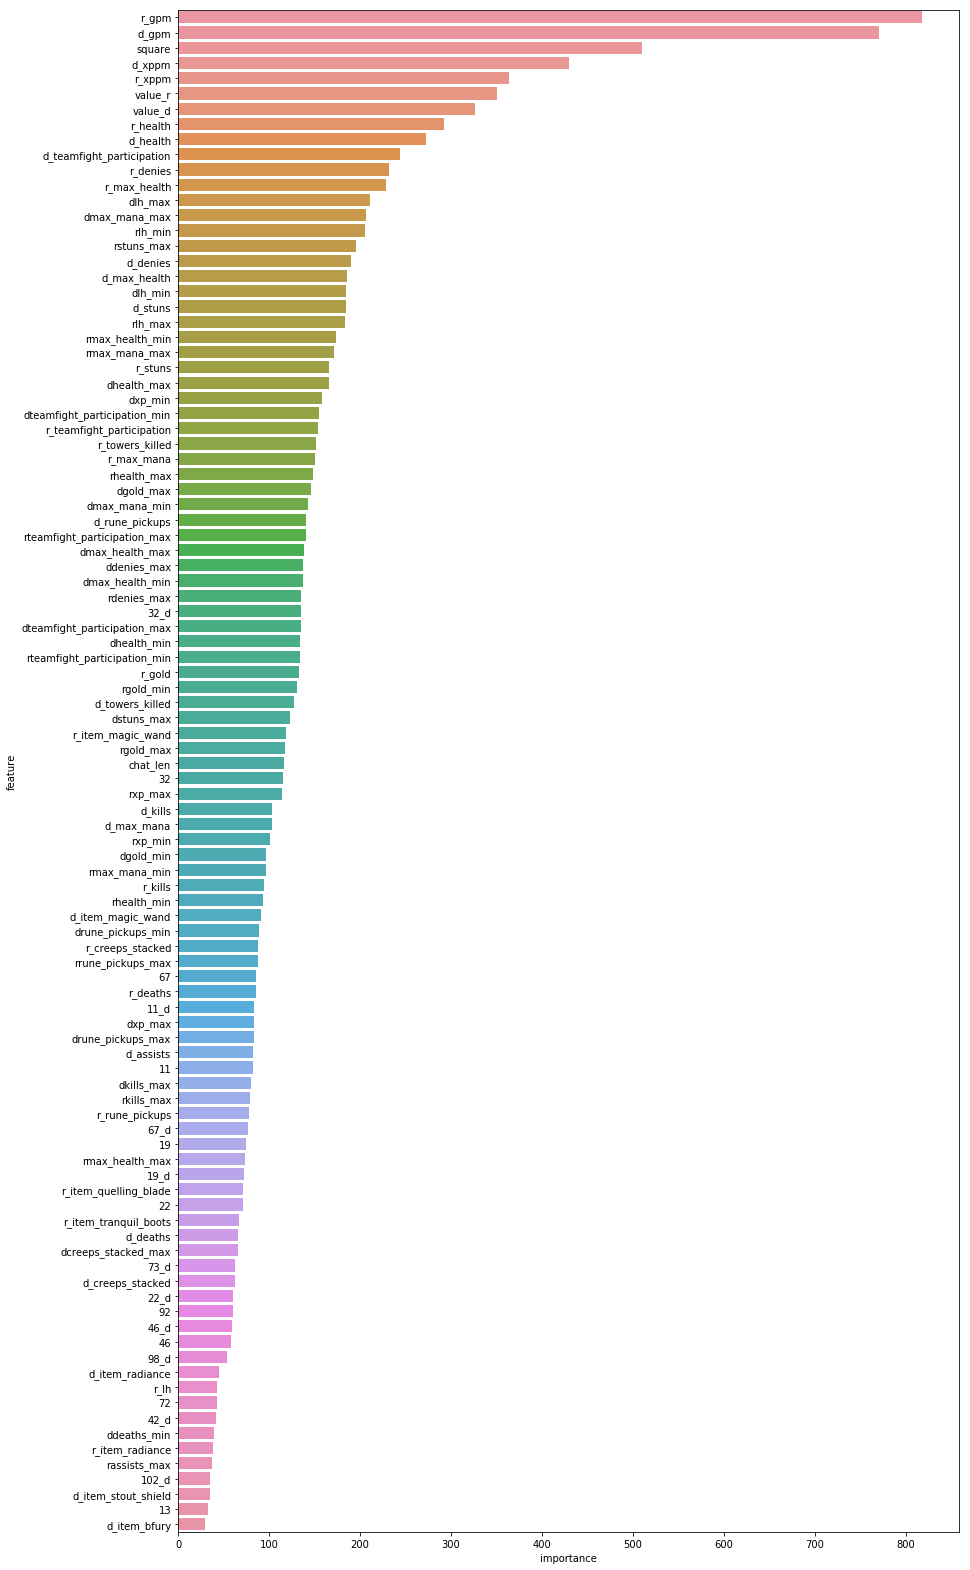

In [188]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':model.feature_importance()}).sort_values('importance', ascending=False)[:100]

plt.figure(figsize=(14,28))
sns.barplot(x=feature_importance.importance, y=feature_importance.feature);

In [186]:
X_train = X_train[feature_importance.feature[:600]]
X_test = X_test[feature_importance.feature[:600]]

In [ ]:
X_test.drop(columns = ['d_xppm', 'r_xppm'], inplace = True, axis = 1)

In [185]:
X_train.shape

(37542, 745)

In [86]:
df_submission_extended = pd.DataFrame(
    {'radiant_win_prob': y_pr[:,1]}, 
    index=test_data.index)
df_submission_extended.to_csv('submission63.csv')

In [ ]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
            
        if model_type == 'lgb':
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores
    
            

In [ ]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [ ]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

X = train.reset_index(drop=True)
y = tr['radiant_win']
X_test = test.copy().reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [ ]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

df_submission_extended = pd.DataFrame(
    {'radiant_win_prob': y_pred}, 
    index=test_data.index)
df_submission_extended.to_csv('submission3.csv')

In [7]:
def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file, encoding='UTF-8') as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

In [9]:
json_list = [] #store data that are read
number_of_rows = 50 #how many lines to read 

#reading data from .jsonl file
with open('train_matches.jsonl') as fin:
    for i in range(number_of_rows):
        line = fin.readline()
        json_list.append(json.loads(line))
        
#how many matches to read. For example I took 1
for i in range(1, 2):
  for j in range(1, 2):#there is 5 players in each team. But I want to look on only one player.
    print(json.dumps(json_list[i]['players'][j], indent=4, sort_keys=True))



{
    "ability_upgrades":[
        {
            "ability":5514,
            "level":1,
            "time":232
        },
        {
            "ability":5515,
            "level":2,
            "time":304
        },
        {
            "ability":5515,
            "level":3,
            "time":322
        },
        {
            "ability":5514,
            "level":4,
            "time":391
        },
        {
            "ability":5515,
            "level":5,
            "time":499
        },
        {
            "ability":5517,
            "level":6,
            "time":581
        }
    ],
    "ability_uses":{
        "centaur_double_edge":11,
        "centaur_hoof_stomp":8,
        "centaur_stampede":2
    },
    "account_id_hash":"1c2500195e6ab646fc9371344724aa77",
    "actions":{
        "1":3679,
        "10":183,
        "11":8,
        "15":19,
        "16":18,
        "19":14,
        "2":2,
        "33":183,
        "4":810,
        "5":4,
        "6":42,
        "7":12,


In [10]:
for i in range(1, 5): #now we will look at 4 matches
  for j in range(1, 5):#and now will take 5 players
    print(json.dumps(list(map(lambda x: x['id'][5:], json_list[i]['players'][j]['hero_inventory'])), indent=4, sort_keys=True))

[
    "stout_shield",
    "soul_ring",
    "tranquil_boots",
    "chainmail"
]
[
    "magic_wand",
    "dust",
    "boots",
    "ward_dispenser",
    "tpscroll"
]
[
    "magic_wand",
    "pers",
    "blight_stone",
    "tpscroll",
    "ring_of_aquila"
]
[
    "boots",
    "stout_shield",
    "tpscroll"
]
[
    "tango",
    "flask",
    "stout_shield",
    "clarity",
    "enchanted_mango",
    "tpscroll"
]
[
    "stout_shield",
    "blight_stone",
    "tpscroll"
]
[
    "stout_shield",
    "quelling_blade",
    "tango",
    "tpscroll"
]
[
    "tango",
    "faerie_fire",
    "tpscroll"
]
[
    "soul_ring",
    "stout_shield",
    "magic_wand",
    "boots",
    "faerie_fire",
    "tpscroll"
]
[
    "boots",
    "bottle",
    "null_talisman",
    "helm_of_iron_will",
    "null_talisman"
]
[
    "tranquil_boots",
    "magic_stick",
    "orb_of_venom",
    "ward_observer"
]
[
    "power_treads",
    "quelling_blade",
    "clarity",
    "ring_of_health",
    "tpscroll"
]
[
    "ring_of_basili

In [2]:
import collections


def extract_features_csv(match):
    
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]

    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        row.append( (f'{player_name}_items', list(map(lambda x: x['key'], player['purchase_log'])) ) )
        #here u can extract other data

    return collections.OrderedDict(row)

    
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])


In [3]:
def extract_inverse_features_csv(match):
    
    row = [
        ('match_id_hash', match['match_id_hash'][::-1]),
    ]

    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'd%d' % (slot + 1)
        else:
            player_name = 'r%d' % (slot - 4)

        row.append( (f'{player_name}_items', list(map(lambda x: x['key'], player['purchase_log'])) ) )
        #here u can extract other data

    return collections.OrderedDict(row)

In [4]:
def create_features_from_jsonl(matches_file):
  
    df_new_features = []

    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']
        features = extract_features_csv(match)

        df_new_features.append(features)

    df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
    return df_new_features


def create_inverse_features_from_jsonl(matches_file):
  
    df_new_features = []

    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']
        features = extract_features_csv(match)
        inverse_features = extract_inverse_features_csv(match)

        df_new_features.append(features)
        df_new_features.append(inverse_features)

    df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
    return df_new_features

In [5]:
def add_items_dummies(train_df, test_df):
    
    full_df = pd.concat([train_df, test_df], sort=False)
    train_size = train_df.shape[0]

    for team in 'r', 'd':
        players = [f'{team}{i}' for i in range(1, 6)]
        item_columns = [f'{player}_items' for player in players]

        d = pd.get_dummies(full_df[item_columns[0]].apply(pd.Series).stack()).sum(level=0, axis=0)
        dindexes = d.index.values

        for c in item_columns[1:]:
            d = d.add(pd.get_dummies(full_df[c].apply(pd.Series).stack()).sum(level=0, axis=0), fill_value=0)
            d = d.iloc[dindexes]

        full_df = pd.concat([full_df, d.add_prefix(f'{team}_item_')], axis=1, sort=False)
        full_df.drop(columns=item_columns, inplace=True)

    train_df = full_df.iloc[:train_size, :]
    test_df = full_df.iloc[train_size:, :]

    return train_df, test_df


def drop_consumble_items(train_df, test_df):
    
    full_df = pd.concat([train_df, test_df], sort=False)
    train_size = train_df.shape[0]

    for team in 'r', 'd':
        consumble_columns = ['tango', 'tpscroll', 
                             'bottle', 'flask',
                            'enchanted_mango', 'clarity',
                            'faerie_fire', 'ward_observer',
                            'ward_sentry']
        
        starts_with = f'{team}_item_'
        consumble_columns = [starts_with + column for column in consumble_columns]
        full_df.drop(columns=consumble_columns, inplace=True)

    train_df = full_df.iloc[:train_size, :]
    test_df = full_df.iloc[train_size:, :]

    return train_df, test_df


In [8]:
train_df = create_inverse_features_from_jsonl('train_matches.jsonl').fillna(0)
test_df = create_features_from_jsonl('test_matches.jsonl').fillna(0)
print('done')


done


In [9]:
new_train, new_test = add_items_dummies(train_df, test_df)

new_train, new_test = drop_consumble_items(new_train, new_test)

KeyboardInterrupt: 

In [13]:
%%time
train_df = create_features_from_jsonl('train_matches.jsonl').fillna(0)
test_df = create_features_from_jsonl('test_matches.jsonl').fillna(0)


CPU times: user 1min 8s, sys: 2.32 s, total: 1min 10s
Wall time: 1min 10s


In [14]:
matches_file = 'train_matches.jsonl'
MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
_, filename = os.path.split(matches_file)
total_matches = MATCHES_COUNT.get(filename)

In [ ]:
train_df['r1_items'].head()

In [ ]:
import pickle as pkl

#Better to save extracted data in files, because extracting takes time...
train_df.to_pickle('df_train.pkl')
test_df.to_pickle('df_test.pkl')

In [ ]:
def add_items_dummies(train_df, test_df):
    
    full_df = pd.concat([train_df, test_df], sort=False)
    train_size = train_df.shape[0]

    for team in 'r', 'd':
        players = [f'{team}{i}' for i in range(1, 6)]
        item_columns = [f'{player}_items' for player in players]

        d = pd.get_dummies(full_df[item_columns[0]].apply(pd.Series).stack()).sum(level=0, axis=0)
        dindexes = d.index.values

        for c in item_columns[1:]:
            d = d.add(pd.get_dummies(full_df[c].apply(pd.Series).stack()).sum(level=0, axis=0), fill_value=0)
            d = d.ix[dindexes]

        full_df = pd.concat([full_df, d.add_prefix(f'{team}_item_')], axis=1, sort=False)
        full_df.drop(columns=item_columns, inplace=True)

    train_df = full_df.iloc[:train_size, :]
    test_df = full_df.iloc[train_size:, :]

    return train_df, test_df

In [ ]:
def drop_consumble_items(train_df, test_df):
    
    full_df = pd.concat([train_df, test_df], sort=False)
    train_size = train_df.shape[0]

    for team in 'r', 'd':
        consumble_columns = ['tango', 'tpscroll', 
                             'bottle', 'flask',
                            'enchanted_mango', 'clarity',
                            'faerie_fire', 'ward_observer',
                            'ward_sentry', 'branches', 'courier','dust','infused_raindrop',
                            'orb_of_venom', 'tome_of_knowledge', 'tango_single',
                            'smoke_of_deceit']
        
        starts_with = f'{team}_item_'
        consumble_columns = [starts_with + column for column in consumble_columns]
        full_df.drop(columns=consumble_columns, inplace=True)

    train_df = full_df.iloc[:train_size, :]
    test_df = full_df.iloc[train_size:, :]

    return train_df, test_df

In [ ]:
%%time

train_df, test_df = add_items_dummies(train_df, test_df)
train_df, test_df = drop_consumble_items(train_df, test_df)

#target = pd.DataFrame(y)